<font size = 6> Выявление закономерностей определяющих успешность игры </font>

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры.  
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.

**Задача:** Выявить определяющие успешность игры закономерности. 

**Описание данных**
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

# Получение данных

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import math
from tqdm import tqdm
import numpy as np
import scipy.stats as stats

In [2]:
pd.set_option('mode.chained_assignment', None)

In [3]:
# читаем данные и выводим info и первые 5 строк
try:
    df = pd.read_csv('games.csv')
except Exception as e:
    print(f'{e} Локальная версия файла не найдена. Загрузка с ЯП')
    df = pd.read_csv('https://***/games.csv')

print('Размер датасета', df.shape)
print('')
df.info()
display(df.head())

Размер датасета (16715, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# Для нагладности, выведем долю пропусков от общего числа записей
pd.DataFrame((df.isna().mean()*100))

,0
Name,0.011965
Platform,0.000000
Year_of_Release,1.609333
Genre,0.011965
NA_sales,0.000000
EU_sales,0.000000
JP_sales,0.000000
Other_sales,0.000000
Critic_Score,51.319174
User_Score,40.089740


**Вывод**  
Имеем данные состоящие из 16715 строк и 11 столбцов. Незначительное количество пропусков в 'Name' и 'Genre'. Для некоторых позиций не указан год релиза. Около поливины записей имеют пропуски в оценке критиков. Для некоторых полей необходима замена форматов.

# Подготовка данных

Приведем название столбцов к нижнему регистру

In [5]:
for col in df.columns: 
    df.rename(columns={col: col.lower()}, inplace=True)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Около 1.6% данных имеют пропуски в графе год выпуска. Число пропусков незначительно. При исследовании по этому полю, возможно будут проводиться группировки. Поэтому удалим такие данные.

In [6]:
# Удаляем строки с пропуском по году выпуска
df.dropna(subset = ['year_of_release'], inplace = True)
# Проверка
pd.DataFrame((df.isna().mean()*100))

,0
name,0.012161
platform,0.000000
year_of_release,0.000000
genre,0.012161
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.459321
user_score,40.173902


Посмотрим на строки с пропусками в полях название и жанр.

In [7]:
display(df.loc[df['name'].isna()])
display(df.loc[df['genre'].isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Число таких записей незначительно. Влиание на исследования не окажут. Удаляем.

In [8]:
# Удаляем строки с пропуском по году выпуска
df.dropna(subset = ['name', 'genre'], inplace = True)
# Проверка
pd.DataFrame((df.isna().mean()*100))

,0
name,0.000000
platform,0.000000
year_of_release,0.000000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.453418
user_score,40.166626


Изменим тип данных поля 'year_of_release' на целочисленный, для лучшего визуального восприятия и последующей обработки.

In [9]:
df['year_of_release'] = df['year_of_release'].astype(int)
# проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(5), int32(1), object(5)
memory usage: 1.4+ MB


Добавим столбец с суммарными продажами по всем регионам.

In [10]:
df.insert(
    loc=8, 
    column='total_sales', 
    value = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1))
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,NaN,NaN,NaN


Поле critic_score должно содержать целочисленную оценку до 100. Посмотрим на уникальные значения.

In [11]:
print("Уникальные значения поля 'critic_score' - ", df['critic_score'].unique())
print("Минимальное  знаяение поля 'critic_score' - ", df['critic_score'].min())
print("Максимальное знаяение поля 'critic_score' - ", df['critic_score'].max())

Уникальные значения поля 'critic_score' -  [76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65. 54.
 20. 53. 37. 38. 33. 52. 30. 32. 43. 45. 51. 40. 46. 39. 34. 41. 36. 31.
 27. 35. 26. 19. 28. 23. 24. 21. 17. 13.]
Минимальное  знаяение поля 'critic_score' -  13.0
Максимальное знаяение поля 'critic_score' -  98.0


Посмотрим на уникальные значения 'user_score'

In [12]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Посмотрим число повторов

In [13]:
df['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
0.5       2
0.9       2
1.5       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

Помимо пропусков имеем оценку 0 и записи с еще не присвоенными оценками (tbd).  
Распределение tbd по годам.

In [14]:
df[df['user_score'] == 'tbd'].groupby('year_of_release').agg({'user_score': 'count'})

,user_score
year_of_release,
1997,1
1999,8
2000,43
2001,82
2002,192
2003,95
2004,107
2005,121
2006,124


Относительно последного, 2016 года, tbd есть в данных и за более ранние периоды. Возможно причина в малом количесве проданных копий. 

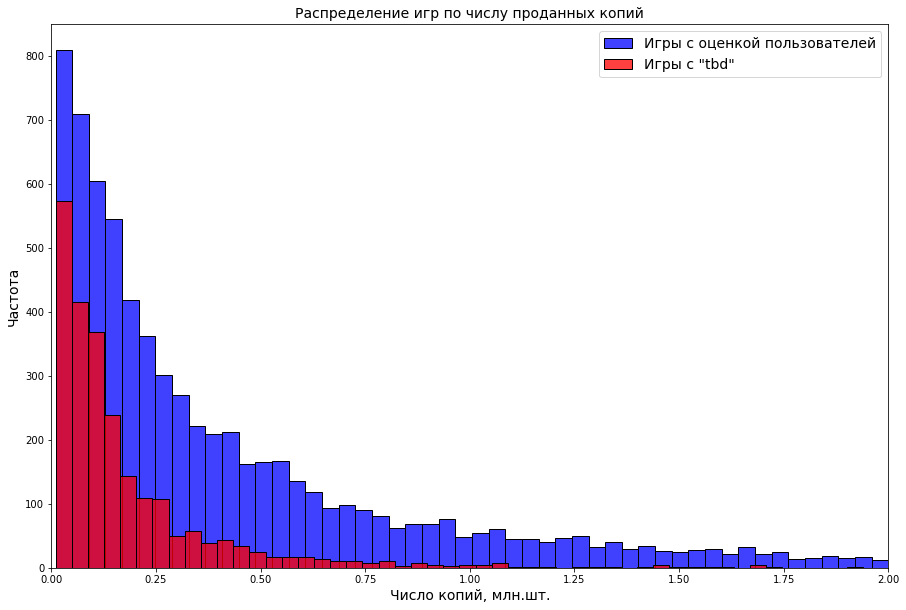

In [15]:
plt.figure(figsize=(15,10))
sns.histplot(
    x="total_sales", 
    data=df.loc[(df['user_score'] != 'tbd') & (df['user_score'].isna()== False) & (df['total_sales'] <= 2)], 
    color='b', 
    bins=50)
sns.histplot(
    x="total_sales", 
    data=df.loc[(df['user_score'] == 'tbd') & (df['total_sales'] <= 2)], 
    color='r',
    bins=50)
plt.title("Распределение игр по числу проданных копий", fontsize=14)
plt.xlabel("Число копий, млн.шт.", fontsize=14)
plt.ylabel("Частота", fontsize=14)
plt.legend(['Игры с оценкой пользователей', 'Игры с "tbd"'], fontsize=14)
plt.xlim(0, 2)
plt.show()

Гистограмма частично подтверждает версию, что основное количество игр с tbd имеет низкий показатель числа копий.

Посмотрим существует ли связь между оценками пользователей и критиков. Для этого определим число записей с неопределенной оценкой пользователя, но указанной оценкой критиков.

In [16]:
df.loc[(df['user_score'] == 'tbd') & (df['critic_score'] > 0)]['critic_score'].count()

1056

Число записей с указанной оценкой пользователей, но пропущенной оценкой критиков.

In [17]:
df[df['critic_score'].isna() & (df['user_score'].isna() == False) & (df['user_score'] != "tbd")]['user_score'].count()

569

Теперь определим число записей с обеими оценками.

In [18]:
(
df.loc[
    (df['user_score'] != 'tbd') & 
    (df['user_score'].isna() == False) & 
    (df['critic_score'] > 0)]
    ['critic_score'].count()
)    

6894

In [19]:
# выделим такие записи в отдельную таблицу
df1 = df.loc[(df['user_score'] != 'tbd') & (df['user_score'].isna() == False) & (df['critic_score'] > 0)]
# поменяем тип данных 'user_score'
df1['user_score'] = df1['user_score'].astype(float)
# добавим столбец с отношением 'critic_score' к 'user_score'
df1['score_coefficient'] = df1['critic_score'] / df1['user_score']

In [20]:
# посмотрим на основные характеристики 'critic_score', 'user_score', 'score_coefficient'
df1.loc[:, ['critic_score', 'user_score', 'score_coefficient']].describe().applymap("{0:.2f}".format)

,critic_score,user_score,score_coefficient
count,6894.00,6894.00,6894.00
mean,70.26,7.18,10.11
std,13.86,1.44,3.18
min,13.00,0.50,3.03
25%,62.00,6.50,8.75
50%,72.00,7.50,9.75
75%,80.00,8.20,10.76
max,98.00,9.60,120.00


Для исключения выбросов можно связать оценки через коэффициент 9.75  
Посмотрим на сколько линейна и постоянна зависимость. Для этого построим график зависимости оценки пользователей от оценки критиков.

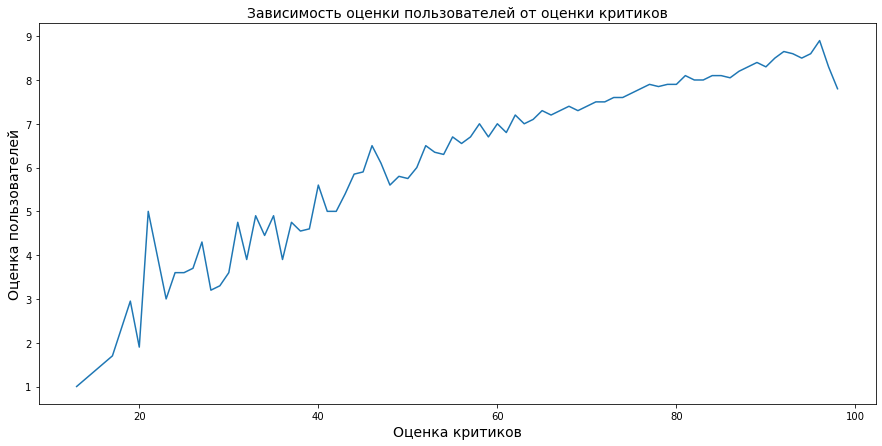

In [21]:
df2 = df1.groupby('critic_score').agg({'user_score': 'median'}).reset_index()
plt.figure(figsize=(15, 7))
sns.lineplot(x='critic_score', y='user_score', data=df2)
plt.title(f'Зависимость оценки пользователей от оценки критиков', fontsize=14)
plt.xlabel("Оценка критиков", fontsize=14)
plt.ylabel("Оценка пользователей", fontsize=14)
plt.show()

Видим, что: 1) зависимоть непостоянна; 2) при оценке от 50 до 95 имеет почти линейный характер.  
Посмотрим на распределение оценок критиков в нашей выборке.

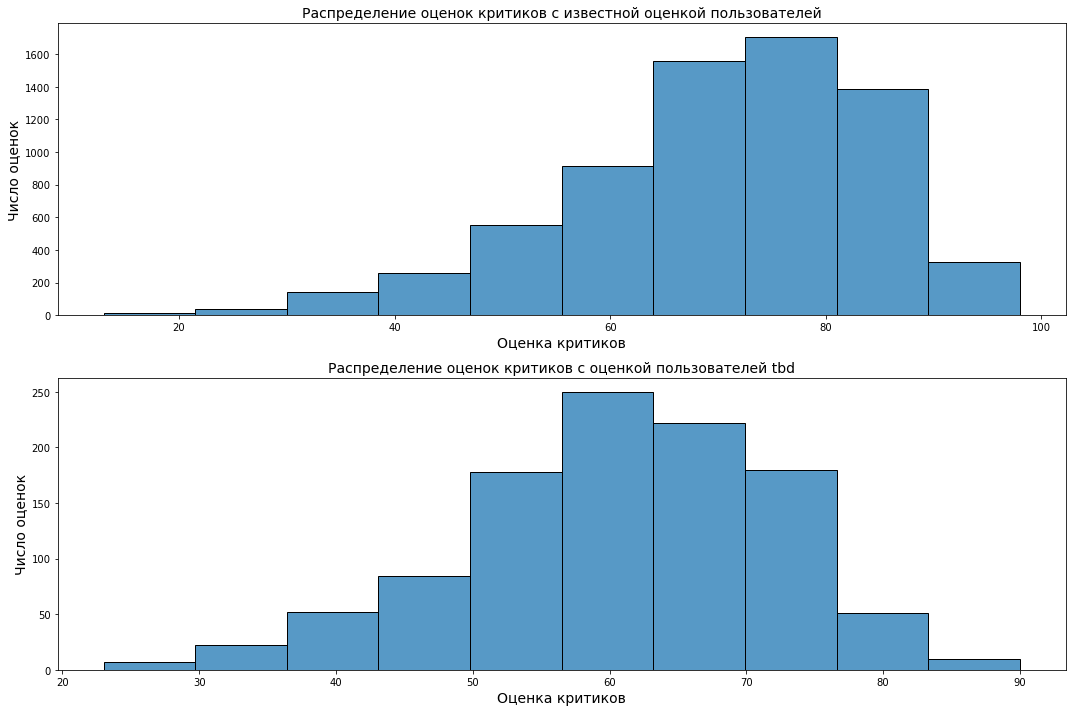

In [22]:
fig1 = plt.figure(figsize=(15,10))
ax1 = fig1.add_subplot(2,1,1)
ax2 = fig1.add_subplot(2,1,2)

sns.histplot(x='critic_score', data=df1, bins=10, ax = ax1)
ax1.set_title("Распределение оценок критиков c известной оценкой пользователей", fontsize=14)
ax1.set_xlabel("Оценка критиков", fontsize=14)
ax1.set_ylabel("Число оценок", fontsize=14)

sns.histplot(x='critic_score', data=df.loc[(df['user_score'] == 'tbd') & (df['critic_score'] > 0)], bins=10, ax = ax2)
ax2.set_title("Распределение оценок критиков с оценкой пользователей tbd", fontsize=14)
ax2.set_xlabel("Оценка критиков", fontsize=14)
ax2.set_ylabel("Число оценок", fontsize=14)

plt.tight_layout()
plt.show()

На первой гистограмме, небольшое число оценок до 40 является причиной колебания коэффициента в этом диапазоне. Вторая диаграмма показывает, что большинство записей с tbd имеют оценки критиков в интервале 50-80.

Построим две модели регресси с помощью модуля statsmodels.

In [23]:
# линейная зависимость вида y = ax + b
formula1 = 'user_score ~ critic_score '

# квадратичная зависимость вида y = ax^2+bx+c
formula2 = 'user_score ~ critic_score + I(critic_score**2)'

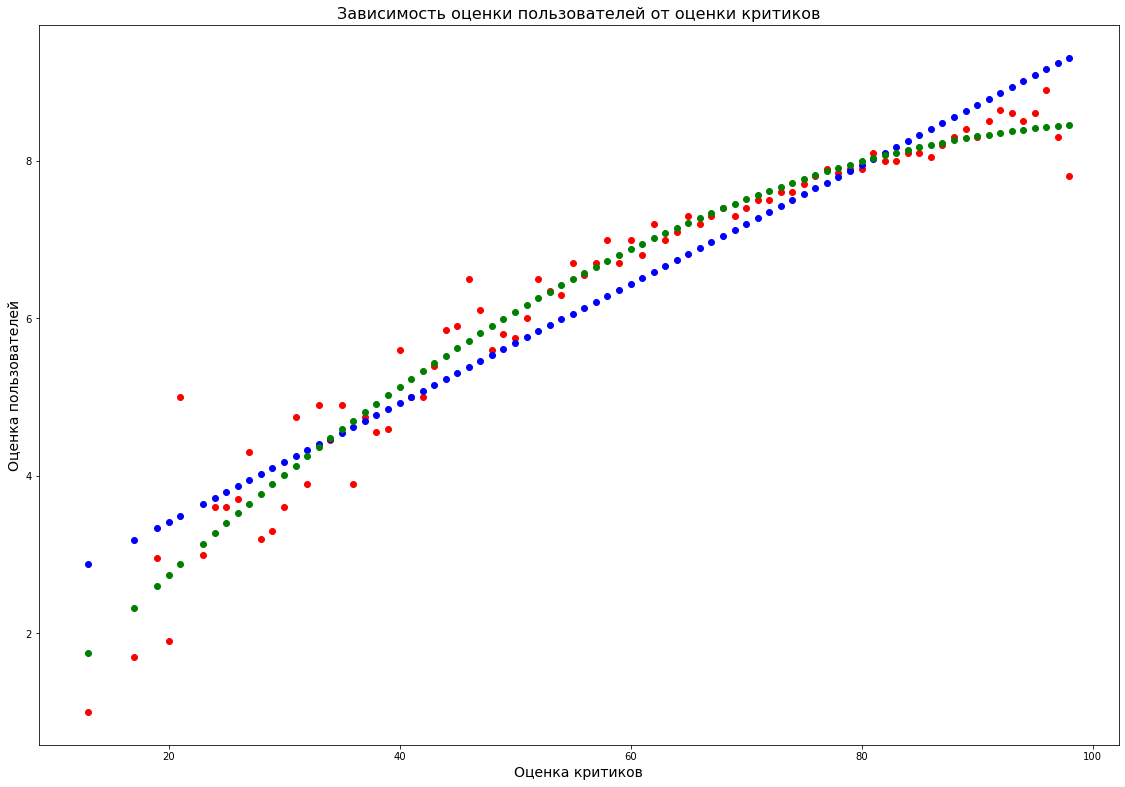

In [24]:
reg1 = smf.ols(formula1, df2).fit()
reg2 = smf.ols(formula2, df2).fit()

y = df2['user_score']
y_reg =  (
        df2['critic_score'] * reg1.params[1] + 
        reg1.params[0])
y_reg2 = (
        df2['critic_score'] *  df2['critic_score'] * reg2.params[2] +  
        df2['critic_score'] * reg2.params[1] + 
        reg2.params[0])
x = df2['critic_score']

fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0,0,1,1])

ax.scatter(x, y, color='r')
ax.scatter(x, y_reg, color='b')
ax.scatter(x, y_reg2, color='g')
ax.set_title("Зависимость оценки пользователей от оценки критиков", fontsize=16)
ax.set_xlabel("Оценка критиков", fontsize=14)
ax.set_ylabel("Оценка пользователей", fontsize=14)


plt.show()

In [25]:
# посмотрим на основные зарактеристики моделей
print(reg1.summary(), reg2.summary())

                            OLS Regression Results                            
Dep. Variable:             user_score   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     788.4
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           7.40e-43
Time:                        11:53:53   Log-Likelihood:                -68.618
No. Observations:                  81   AIC:                             141.2
Df Residuals:                      79   BIC:                             146.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.9033      0.168     11.312   

Выбираем вторую модель, т.е. нелинейную зависимость оценки пользователей от оценки критиков.  
Еще раз гафики.

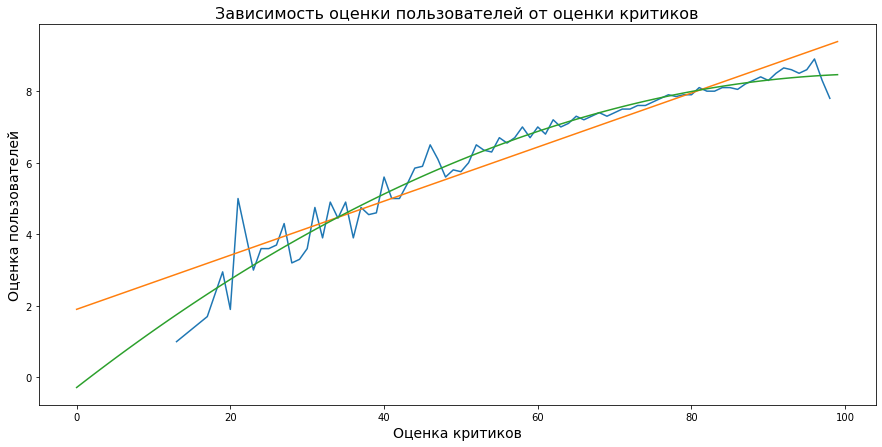

In [26]:
plt.figure(figsize=(15, 7))
sns.lineplot(x='critic_score', y='user_score', data=df2)

sns.lineplot(
    x=[x for x in range(100)], 
    y=[reg1.params[1]*y+reg1.params[0] for y in range(100)])

sns.lineplot(
    x=[x for x in range(100)], 
    y=[reg2.params[2]*y*y+reg2.params[1]*y+reg2.params[0] for y in range(100)])

plt.title("Зависимость оценки пользователей от оценки критиков", fontsize=16)
plt.xlabel("Оценка критиков", fontsize=14)
plt.ylabel("Оценка пользователей", fontsize=14)
plt.show()

In [27]:
# сохраним коэффициенты в переменных a, b, c
a, b, c = reg2.params[2], reg2.params[1], reg2.params[0]

In [28]:
# функция обработки пропусков в оценках пользователей и критиков
def fill_score(row):
    # отбираем строки с tbd NaN в оценке пользователей
    if (row['user_score'] == 'tbd') | (row['user_score'] != row['user_score']):
        # если для таких строк пропус и по оценке критиков, то заполняем все нулями
        if row['critic_score'] != row['critic_score']:
            row['critic_score'] = 0
            row['user_score'] = 0
        # если для таких строк есть оценка критиков, расчитываем оценку пользователей используя модель    
        else: 
            row['user_score'] = round((row['critic_score']*row['critic_score']*a + row['critic_score']*b + c), 1)
    # если строка содержит оценку пользователей, то проверяем нет ли пропуска в оценке критиков        
    else:
        # если оценка критиков отсудствует, то выполняем обратное вычисление используя оценку пользователей
        if row['critic_score'] != row['critic_score']:
            # находим корни квадратного уравнения при условии, что дискримининт больше 0
            c1 = c - float(row['user_score'])
            discr = b ** 2 - 4 * a * c1
            if discr > 0: 
                x1 = (-b + math.sqrt(discr)) / (2 * a)
                x2 = (-b - math.sqrt(discr)) / (2 * a)
                row['critic_score'] = round(min(x1, x2), 0)
                      
    return row        

In [29]:
# Применим функцию к DF, используем tqdm для визуализации процесса
tqdm.pandas()
df = df.progress_apply(fill_score, axis=1)
df['user_score'] = df['user_score'].astype(float)
df.info()

100%|██████████████████████████████████| 16444/16444 [00:03<00:00, 4220.03it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   total_sales      16444 non-null  float64
 9   critic_score     16383 non-null  float64
 10  user_score       16444 non-null  float64
 11  rating           9768 non-null   object 
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


Видим, что у нас осталось порядка 60 пропусков в оценке критиков. Видимо, простая квадратичная зависимость не смогла корректно отработать на крайних значениях. Проверим.

In [30]:
df[df['critic_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
656,Theme Hospital,PC,1997,Strategy,2.30,0.10,0.00,0.00,2.40,NaN,9.0,K-A
682,My Fitness Coach,Wii,2008,Sports,1.18,0.90,0.00,0.24,2.32,NaN,8.6,E
862,Harry Potter and the Chamber of Secrets,PS,2002,Action,0.75,1.09,0.02,0.12,1.98,NaN,8.5,E
2032,Petz: Catz 2,DS,2007,Simulation,0.51,0.40,0.00,0.11,1.02,NaN,9.0,E
2673,Cabela's Deer Hunt: 2004 Season,PS2,2003,Sports,0.37,0.29,0.00,0.10,0.76,NaN,9.0,T
...,...,...,...,...,...,...,...,...,...,...,...,...
15284,Unreal Anthology,PC,2006,Shooter,0.00,0.02,0.00,0.00,0.02,NaN,8.8,M
15422,Fallout Trilogy,PC,2004,Role-Playing,0.00,0.02,0.00,0.00,0.02,NaN,8.9,M
16140,Dead Rising,XOne,2016,Action,0.01,0.00,0.00,0.00,0.01,NaN,8.8,M
16142,MLB 15: The Show,PSV,2015,Sports,0.01,0.00,0.00,0.00,0.01,NaN,8.8,E


In [31]:
# крайние значения
df[df['critic_score'].isna()]['user_score'].describe().apply("{0:.2f}".format)

count    61.00
mean      8.81
std       0.25
min       8.50
25%       8.60
50%       8.80
75%       8.90
max       9.70
Name: user_score, dtype: object

Предположение верно. Для при оценке пользователей выше 8.4, для заполнения пропусков в оценке критиков будем использовать линейный коэффициент пересчета 9.75.

In [32]:
lin_coef = df1['score_coefficient'].median()
round(lin_coef, 2)

9.75

In [33]:
# функция для заполнения пропусков в оценке критиков
def critic_sc(row):
    if row['critic_score'] != row['critic_score']:
        row['critic_score'] = int(row['user_score'] * lin_coef)
    return row    

In [34]:
df = df.progress_apply(critic_sc, axis=1)
df['user_score'] = df['user_score'].astype(float)
df['critic_score'] = df['critic_score'].astype(int)
df.info()

100%|██████████████████████████████████| 16444/16444 [00:02<00:00, 5550.76it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   total_sales      16444 non-null  float64
 9   critic_score     16444 non-null  int32  
 10  user_score       16444 non-null  float64
 11  rating           9768 non-null   object 
dtypes: float64(6), int32(1), int64(1), object(4)
memory usage: 1.6+ MB


Посмотрим на данные по рейтингу.

In [35]:
df['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64

Всесто пропущенных значений рейтинга укажем n/a (Not Available)

In [36]:
df = df.fillna('n/a')
# проверка
pd.DataFrame((df.isna().mean()*100))

,0
name,0.0
platform,0.0
year_of_release,0.0
genre,0.0
na_sales,0.0
eu_sales,0.0
jp_sales,0.0
other_sales,0.0
total_sales,0.0
critic_score,0.0


Проверим данные на дубликаты

In [37]:
df.duplicated().sum()

0

Дубликаты отсутствуют.

Посмотрим на данные по платформам и жанрам

In [38]:
df['platform'].nunique()

31

В данных представленны сведения об играх на 31 платформе.

In [39]:
df['platform'].value_counts()

PS2     2127
DS      2121
PS3     1306
Wii     1286
X360    1232
PSP     1193
PS      1190
PC       957
GBA      811
XB       803
GC       542
3DS      512
PSV      429
PS4      392
N64      316
XOne     247
SNES     239
SAT      173
WiiU     147
2600     116
NES       98
GB        97
DC        52
GEN       27
NG        12
WS         6
SCD        6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64

In [40]:
df['genre'].nunique()

12

В записях игры 12 жанров.

In [41]:
df['genre'].value_counts() 

Action          3307
Sports          2306
Misc            1721
Role-Playing    1481
Shooter         1296
Adventure       1293
Racing          1226
Platform         878
Simulation       857
Fighting         837
Strategy         673
Puzzle           569
Name: genre, dtype: int64

**Выводы:**  
Произведена проверка и подготовка данных. Изменеты форматы, обработаны пропуски.

# Исследовательский анализ данных

In [42]:
pd.set_option('display.float_format', '{:.2f}'.format)

## Выпуск игр по годам

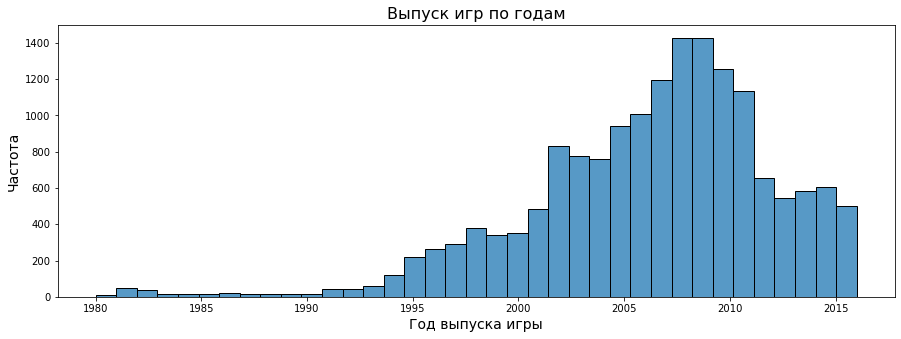

In [43]:
plt.figure(figsize=(15,5))
sns.histplot(x='year_of_release', data=df, bins=df['year_of_release'].nunique())
plt.title("Выпуск игр по годам", fontsize=16)
plt.xlabel("Год выпуска игры", fontsize=14)
plt.ylabel("Частота", fontsize=14)
plt.show()

Число игр с 1980 по 1995 незначительно. Для дальнейшего анализа будем использовать данные по играм с 1996 года. 

In [44]:
df = df.query('year_of_release > 1995')

**Вывод**
Пик выпуска игр приходится на 2008-2009 года. С 1996 по 2008 года рост с незначительми колебаниями. Последующее паденее связано, вороятно, с кризисом 2008 года. Резкое падение, почти в двое, в 2012. После 2012 и по 2016 число игр примерно на одном уровне. В 2013 году самый низкий показатель за предыдушие 10 лет. Можно предположить, что падение производствы связано с падением спроса. Спрос мог упасть после кризиса 2008. Компании-производители большие и инертные. Производство игр процесс долгий. Все это в купе - задержка реагирование на изменения внешней среды 2-3 года.

## Продажи  игр по году выпуска

Посмотрим на число проданных копий по годам и среднее число копий одной игры.

In [45]:
dft32 =(
    df.groupby('year_of_release')
    .agg({'name':'count', 
          'na_sales':'sum', 
          'eu_sales':'sum', 
          'jp_sales':'sum', 
          'other_sales':'sum', 
          'total_sales':'sum'})
    .reset_index()
)
dft32.rename(columns = {'name' : 'qty'}, inplace = True)
dft32['ave_copies'] = round(dft32['total_sales'] / dft32['qty'], 2)
dft32.head()

,year_of_release,qty,na_sales,eu_sales,jp_sales,other_sales,total_sales,ave_copies
0,1996,263,86.76,47.26,57.44,7.69,199.15,0.76
1,1997,289,94.75,48.32,48.87,9.13,201.07,0.70
2,1998,379,128.36,66.90,50.04,11.01,256.31,0.68
3,1999,338,126.06,62.67,52.34,10.04,251.11,0.74
4,2000,350,94.50,52.77,42.77,11.62,201.66,0.58


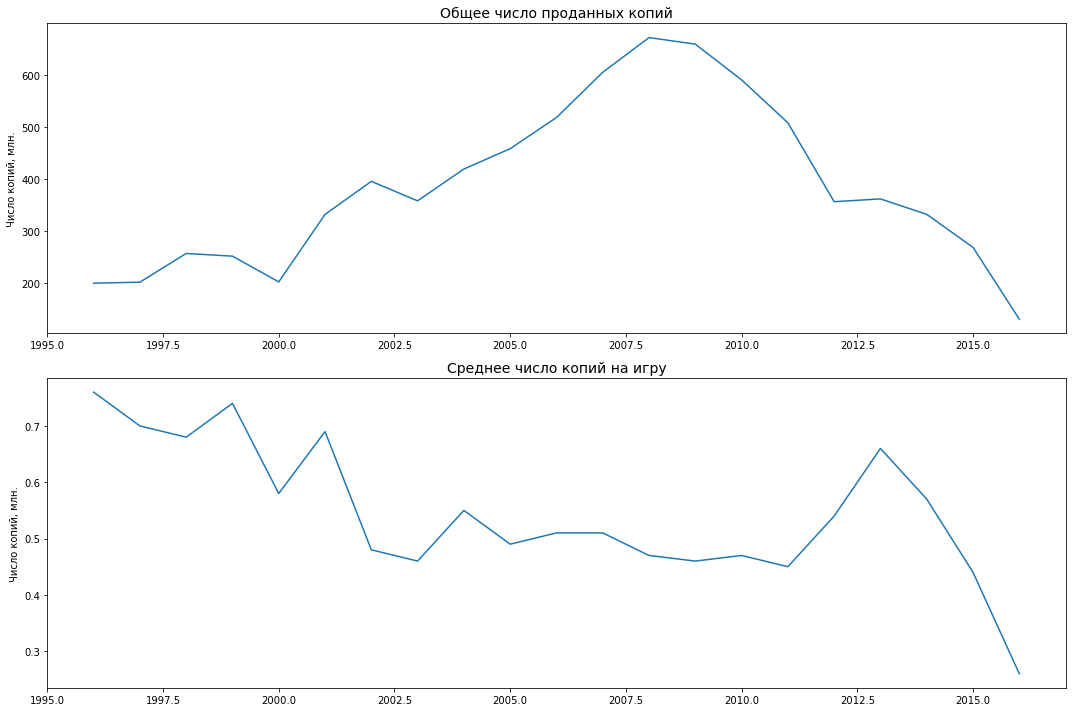

In [46]:
fig32 = plt.figure(figsize=(15,10))
ax1 = fig32.add_subplot(2,1,1)
ax2 = fig32.add_subplot(2,1,2)

ax1.set_title(f'Общее число проданных копий', fontsize=14)
ax1.plot(dft32['year_of_release'], dft32['total_sales'])
ax1.set_ylabel("Число копий, млн.", fontsize=10)

ax2.set_title(f'Среднее число копий на игру', fontsize=14)
ax2.plot(dft32['year_of_release'], dft32['ave_copies'])
ax2.set_ylabel("Число копий, млн.", fontsize=10)

fig32.tight_layout()

Изменение общего числа проданных копий схоже с поведением количесва игр. Обращает внимание высокое значение числа копий в пересчете на 1 игру для игр 2013 года. Помним, что это год с наименьшим числом выпущенных игр. Посмотрим на динамику копий по регионам.

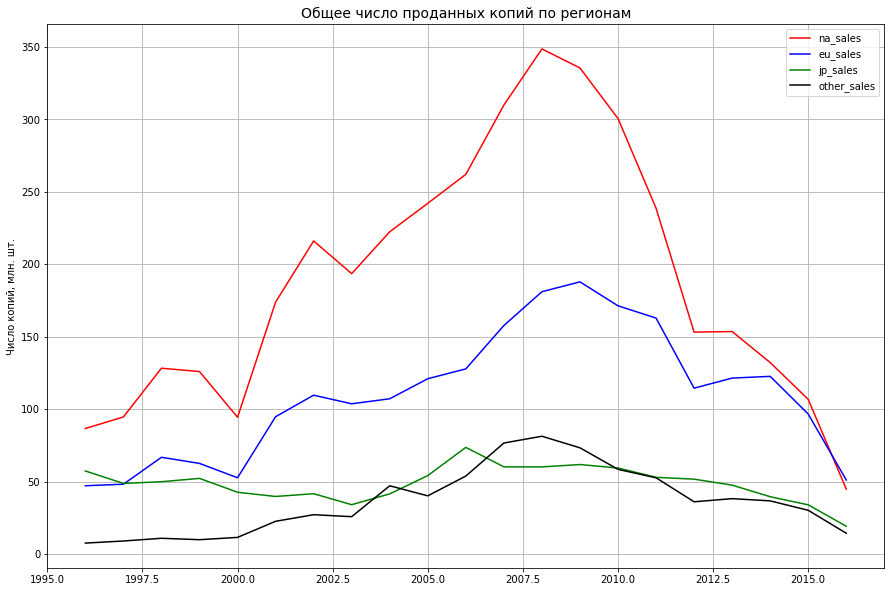

In [47]:
plt.figure(figsize=(15,10))
plt.plot(dft32['year_of_release'], dft32['na_sales'], color='red', label='na_sales')
plt.plot(dft32['year_of_release'], dft32['eu_sales'], color='blue', label='eu_sales')
plt.plot(dft32['year_of_release'], dft32['jp_sales'], color='green', label='jp_sales')
plt.plot(dft32['year_of_release'], dft32['other_sales'], color='black', label='other_sales')

plt.title(f'Общее число проданных копий по регионам', fontsize=14)
plt.ylabel('Число копий, млн. шт.')
plt.legend()
plt.grid()

plt.show()

Все регионы показавают относительно одинаковую динамику по числу копий с поправкой на мультипликатор. Присутствует небольшой отличие для рынка Японии на отрезке 2000-2003 года (другая направленность). Японский рынок показывает относительную стабильность по сравнению с рынками СА и Европы, колебания в пределах 25-75 млн. копий, в то время как рынок СА, на отрезке 1997-2008 годы вырос в 3.5 раза.

## Выпуск игр по платформам

Посмотрим на распределение игр по платформам. Выделим Топ-10 платформ по числу игр, а остальные агрегируем в "Others".

In [48]:
dft1q = df.groupby('platform').agg({'name':'count'}).sort_values(by='name', ascending=False).reset_index()
dft1q.rename(columns = {'name' : 'qty'}, inplace = True)
top10q = dft1q.head(10)
top11q = top10q.append(pd.Series(data={'platform':'Others', 'qty':dft1q.tail(dft1q.shape[0]-10)['qty'].sum()}, name='oth'), ignore_index=False)
top11q = top11q.sort_values(by='qty', ascending=False)
top11q

,platform,qty
oth,Others,2845
0,PS2,2127
1,DS,2120
2,PS3,1306
3,Wii,1286
4,X360,1232
5,PSP,1193
6,PS,1074
7,PC,942
8,GBA,811


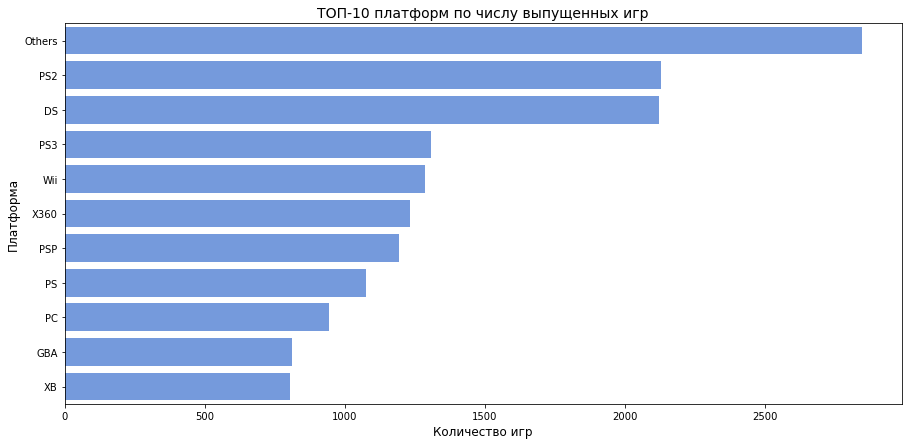

In [49]:
# визуализируем
plt.figure(figsize=(15,7))
sns.barplot(y='platform', x='qty', data=top11q, color='cornflowerblue')
plt.title('TОП-10 платформ по числу выпущенных игр', fontsize=14)
plt.xlabel('Количество игр', fontsize=12)
plt.ylabel('Платформа', fontsize=12)
plt.show()

## Продажи игр по платформам

Посмотрим на распределение продаж по платформам. Выделим Топ-10 платформ, а остальные агрегируем в "Others".

In [50]:
# продажи по платформам
dft1c = df.groupby('platform').agg({'total_sales':'sum'}).sort_values(by='total_sales', ascending=False).reset_index()
dft1c.rename(columns = {'total_sales' : 'c_qty'}, inplace = True)
top10c = dft1c.head(10)
top11c = top10c.append(pd.Series(data={'platform':'Others', 'c_qty':dft1c.tail(dft1c.shape[0]-10)['c_qty'].sum()}, name='oth'), ignore_index=False)
top11c = top11c.sort_values(by='c_qty', ascending=False)
top11c

,platform,c_qty
oth,Others,1386.76
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.76
5,PS,685.59
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53


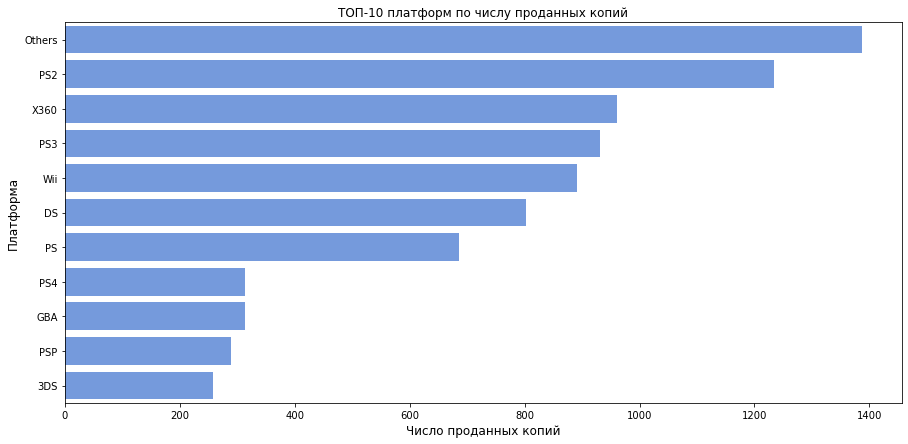

In [51]:
# визуализируем
plt.figure(figsize=(15,7))
sns.barplot(y='platform', x='c_qty', data=top11c, color='cornflowerblue')
plt.title('TОП-10 платформ по числу проданных копий', fontsize=12)
plt.xlabel('Число проданных копий', fontsize=12)
plt.ylabel('Платформа', fontsize=12)
plt.show()

Сравним Топ-10 платформ по числу выпущенных игр и то-10 по числу проданных копий.

In [52]:
top11q.merge(top11c, right_index=True, left_index=True)

,platform_x,qty,platform_y,c_qty
oth,Others,2845,Others,1386.76
0,PS2,2127,PS2,1233.56
1,DS,2120,X360,961.24
2,PS3,1306,PS3,931.34
3,Wii,1286,Wii,891.18
4,X360,1232,DS,802.76
5,PSP,1193,PS,685.59
6,PS,1074,PS4,314.14
7,PC,942,GBA,312.88
8,GBA,811,PSP,289.53


**Выводы** По числу выпущенных игр и про количеству проданных копий лидирует PS2. В ТОП-5 обоих рейтинков список платформ идентичен, 2 платформы от SONY, 2 от Nintendo и 1 от Microsoft. Среди 5 присутствует 1 портативная платформа (DS). И если по числу проданных копий есть явный лидер - PS2, то по числу игр разрыв между 1 и 2 местами не так значителен. Рейтинг по числу проданных копий имеет более четкие градации внутри ТОП-5

## Срок жизни платформы

Посмотрим на число игр по платформам и годам

In [53]:
# установим вывод всех столбцов
pd.set_option("display.max.columns", None)
pl_years_q = df.pivot_table(index='year_of_release', columns='platform', values= 'name', aggfunc='count').reset_index()
pl_years_q

platform,year_of_release,3DS,DC,DS,GB,GBA,GC,N64,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SNES,WS,Wii,WiiU,X360,XB,XOne
0,1996,NaN,NaN,NaN,6.00,NaN,NaN,18.00,2.00,4.00,1.00,164.00,NaN,NaN,NaN,NaN,NaN,38.00,30.00,NaN,NaN,NaN,NaN,NaN,NaN
1,1997,NaN,NaN,NaN,8.00,NaN,NaN,49.00,NaN,6.00,NaN,188.00,NaN,NaN,NaN,NaN,NaN,34.00,4.00,NaN,NaN,NaN,NaN,NaN,NaN
2,1998,NaN,7.00,NaN,8.00,NaN,NaN,77.00,NaN,8.00,NaN,248.00,NaN,NaN,NaN,NaN,NaN,29.00,2.00,NaN,NaN,NaN,NaN,NaN,NaN
3,1999,NaN,14.00,NaN,11.00,NaN,NaN,102.00,NaN,7.00,NaN,200.00,NaN,NaN,NaN,NaN,NaN,1.00,1.00,2.00,NaN,NaN,NaN,NaN,NaN
4,2000,NaN,20.00,NaN,17.00,1.00,NaN,60.00,NaN,7.00,NaN,160.00,82.00,NaN,NaN,NaN,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.00,NaN
5,2001,NaN,8.00,NaN,10.00,107.00,22.00,9.00,NaN,15.00,NaN,91.00,185.00,NaN,NaN,NaN,NaN,NaN,NaN,2.00,NaN,NaN,NaN,33.00,NaN
6,2002,NaN,1.00,NaN,NaN,198.00,152.00,1.00,NaN,19.00,NaN,20.00,280.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.00,NaN
7,2003,NaN,NaN,NaN,NaN,150.00,144.00,NaN,NaN,33.00,NaN,3.00,256.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189.00,NaN
8,2004,NaN,NaN,23.00,NaN,175.00,83.00,NaN,NaN,30.00,NaN,NaN,259.00,NaN,NaN,15.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177.00,NaN
9,2005,NaN,NaN,118.00,NaN,135.00,97.00,NaN,NaN,37.00,NaN,NaN,260.00,NaN,NaN,95.00,NaN,NaN,NaN,NaN,NaN,NaN,18.00,179.00,NaN


Для каждой из платформ посчитаем срок жизни (число активных лет). Будем считать "активными" года в которых выпущено более 1 игры.

In [54]:
# список платформ
platforms = pl_years_q.columns[1:].to_list()
# меняем единицы на пропуски
pl_by_years = pl_years_q
for platform in platforms: 
    pl_by_years = pl_by_years.replace({platform:{1:np.nan}}) 
# pl_by_years

In [55]:
# срок жизни
life_time = []
for platform in platforms:
    life_time.append(pl_by_years[platform].count())
dic = {'platform': platforms, 'life_time': life_time}
life_time = pd.DataFrame(dic)  
life_time.sort_values(by='life_time', ascending=False)

,platform,life_time
8,PC,21
14,PSP,12
21,X360,12
11,PS2,12
12,PS3,11
2,DS,10
19,Wii,10
10,PS,8
22,XB,7
4,GBA,7


Дольше всего "живут" игры для PC. Далее в первой десятке следуют SONY (семейство PS*), NINTENDO (DS, Wii, GBA) и Microsoft (X360. XB)

In [56]:
# список ТОП-10 платформ по числу копий
top10c_platform = top10c['platform'].to_list()
# основный стат.характеристики продолжительности жизни для ТОП-10 платформ
life_time.query('platform in @top10c_platform').describe()

,life_time
count,10.00
mean,9.20
std,2.82
min,4.00
25%,7.25
50%,10.00
75%,11.75
max,12.00


In [57]:
# основный стат.характеристики продолжительности жизни для всех платформ
life_time.describe()

,life_time
count,24.00
mean,7.00
std,4.54
min,0.00
25%,4.00
50%,6.00
75%,10.00
max,21.00


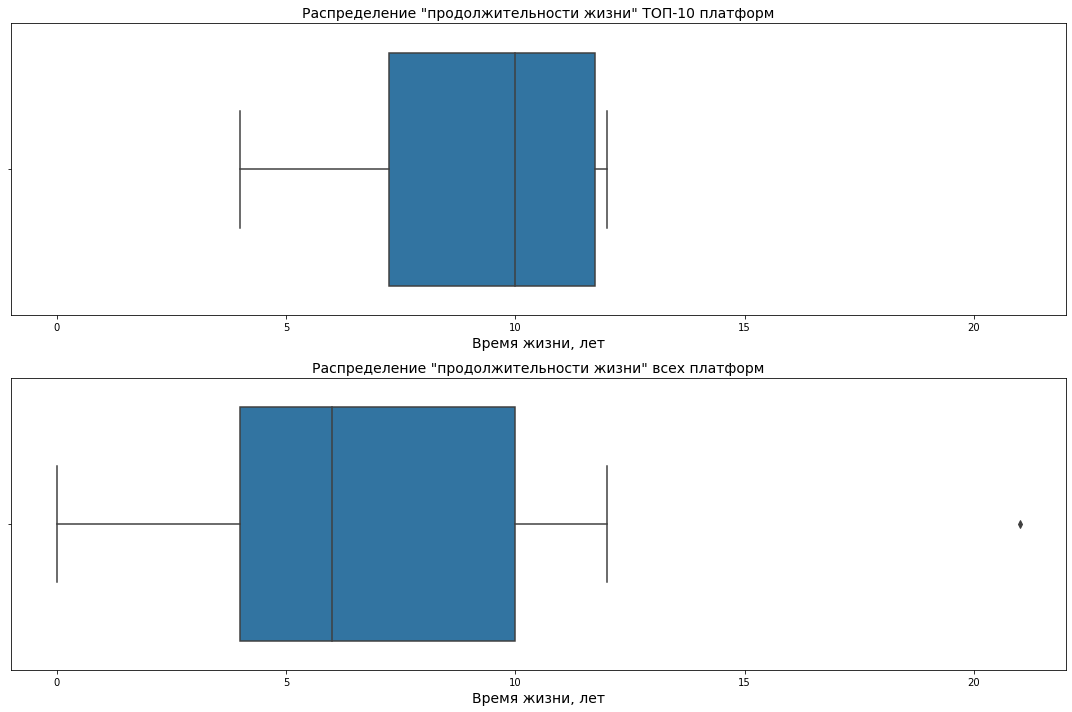

In [58]:
# визуализируем
fig3 = plt.figure(figsize=(15,10))
ax1 = fig3.add_subplot(2,1,1)
ax2 = fig3.add_subplot(2,1,2)

sns.boxplot(x='life_time', data=life_time.query('platform in @top10c_platform'), ax = ax1)
ax1.set_title('Распределение "продолжительности жизни" ТОП-10 платформ', fontsize=14)
ax1.set_xlabel("Время жизни, лет", fontsize=14)
ax1.set_xlim(-1, 22)

sns.boxplot(x='life_time', data=life_time, ax = ax2)
ax2.set_title('Распределение "продолжительности жизни" всех платформ', fontsize=14)
ax2.set_xlabel("Время жизни, лет", fontsize=14)
ax2.set_xlim(-1, 22)

fig3.tight_layout()

В среднем платформы "живут" около 6 лет. PC видится платформой, которая будет существовать всегда. Половина платформ имеют срок от 4 до 10 лет, четверть - менее 4 лет и еще четверть - 10 и белее лет. Для платформ из ТОП-10 характерно более длительное существование - 7-12лет, при медиане 10

На тепловой карте отобразим число выпущенных игр по платформам/годам и число проданных копий по платформам/годам рилиза. 

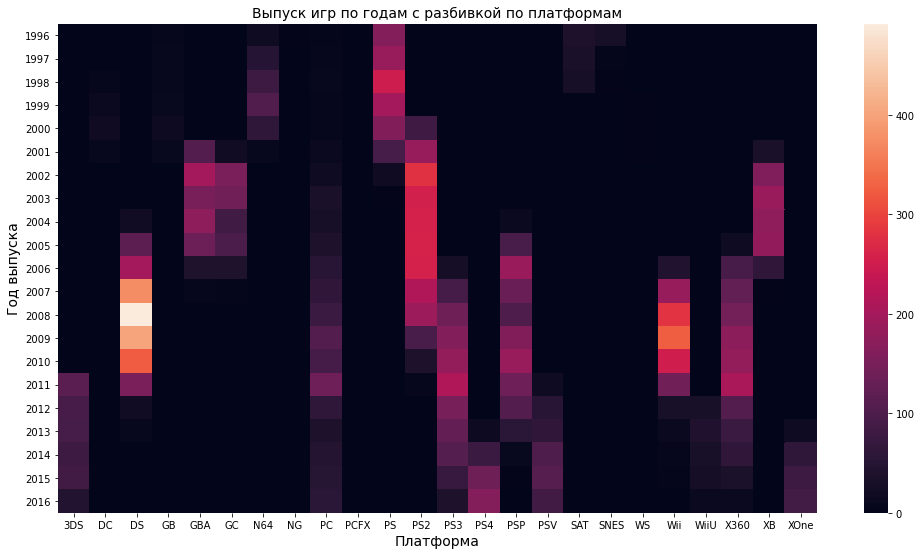

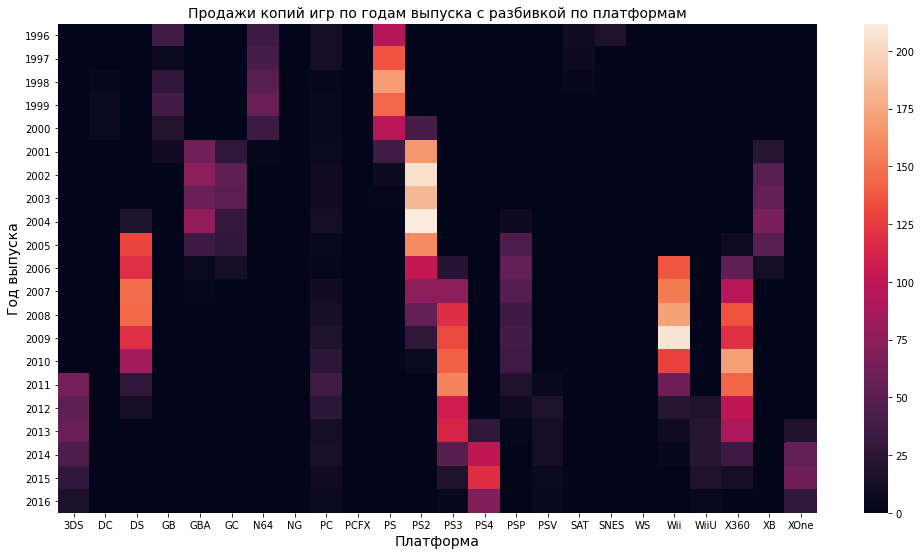

In [59]:
dftq = df.pivot_table(index='year_of_release', columns='platform', values= 'name', aggfunc='count').fillna(0)
plt.figure(figsize=(17,9))
sns.heatmap(dftq)
plt.title("Выпуск игр по годам с разбивкой по платформам", fontsize=14)
plt.xlabel("Платформа", fontsize=14)
plt.ylabel("Год выпуска", fontsize=14)
plt.show()
dftc = df.pivot_table(index='year_of_release', columns='platform', values= 'total_sales', aggfunc='sum').fillna(0)
plt.figure(figsize=(17,9))
sns.heatmap(dftc)
plt.title("Продажи копий игр по годам выпуска с разбивкой по платформам", fontsize=14)
plt.xlabel("Платформа", fontsize=14)
plt.ylabel("Год выпуска", fontsize=14)
plt.show()

**Выводы**
- лидер по выпуску игр в год NINTENDO (DS, Wii), наилучший результат - платформа  DS в 2008году
- хорошо видна смена поколений SONY (PS > PS2 > PS3 > PS4) Наибольшее число игр выпущено для PS2
- более резкая смена поколений для платформ Microsoft
- лидер по числу проданных копий в год платформы PS2(игры 2004 и 2002) и Wii(игры 2009)
- по предосталенным данным можно говорить о потенциале роста на платформах PS4, XOne и стабильном состоянии по PС
- как правило, пик платформы приходится на середину жизненного цикла, т.е. 5-6 годы для ТОП-10 платформ

## Прогнозирование данных будущего периода

Для прогноза будем использовать данные за последние несколько лет, для "живых" платформ.  
Исходя из ранее принятого срока жизни платфориы будем определять тренд изменения числа игр на следующий период.  
Используя данные о числе проданных копий определим средние годовые продажи. 

In [60]:
# вспомогательная таблица с продажами по годам/платформам
pl_years_c = df.pivot_table(index='year_of_release', columns='platform', values= 'total_sales', aggfunc='sum').reset_index()
pl_years_c.tail(5)

platform,year_of_release,3DS,DC,DS,GB,GBA,GC,N64,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SNES,WS,Wii,WiiU,X360,XB,XOne
16,2012,51.36,NaN,11.01,NaN,NaN,NaN,NaN,NaN,23.22,NaN,NaN,NaN,107.36,NaN,7.69,16.19,NaN,NaN,NaN,21.71,17.56,99.74,NaN,NaN
17,2013,56.57,NaN,1.54,NaN,NaN,NaN,NaN,NaN,12.38,NaN,NaN,NaN,113.25,25.99,3.14,10.59,NaN,NaN,NaN,8.59,21.65,88.58,NaN,18.96
18,2014,43.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.28,NaN,NaN,NaN,47.76,100.00,0.24,11.90,NaN,NaN,NaN,3.75,22.03,34.74,NaN,54.07
19,2015,27.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.52,NaN,NaN,NaN,16.82,118.90,0.12,6.25,NaN,NaN,NaN,1.14,16.35,11.96,NaN,60.14
20,2016,15.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.25,NaN,NaN,NaN,3.60,69.25,NaN,4.25,NaN,NaN,NaN,0.18,4.60,1.52,NaN,26.15


In [61]:
# заведём переменную с годом прогноза
for_year = 2017
# список платформ на которых выпускались игры за предыдущий год
pl_for_forecast = pl_years_q.query('year_of_release > (@for_year -2)').dropna(axis=1, how='all').columns
# выпущенные игры по платформам за последние 10 лет
forecast_q = pl_years_q.query('year_of_release > @for_year-10')[pl_for_forecast]
forecast_q

platform,year_of_release,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
12,2008,NaN,76.00,138.00,NaN,NaN,282.00,NaN,146.00,NaN
13,2009,NaN,107.00,162.00,NaN,NaN,325.00,NaN,172.00,NaN
14,2010,NaN,90.00,181.00,NaN,NaN,253.00,NaN,182.00,NaN
15,2011,116.00,139.00,215.00,NaN,18.00,143.00,NaN,206.00,NaN
16,2012,93.00,61.00,148.00,NaN,53.00,31.00,32.00,106.00,NaN
17,2013,91.00,38.00,126.00,16.00,63.00,12.00,42.00,75.00,19.00
18,2014,80.00,47.00,108.00,75.00,100.00,6.00,31.00,63.00,61.00
19,2015,86.00,50.00,73.00,137.00,110.00,4.00,28.00,35.00,80.00
20,2016,46.00,54.00,38.00,164.00,85.00,1.00,14.00,13.00,87.00


In [62]:
# продажи по платформам за тот же период
pl_for_forecast = pl_years_c.query('year_of_release > (@for_year -2)').dropna(axis=1, how='all').columns
forecast_c = pl_years_c.query('year_of_release > @for_year-10')[pl_for_forecast]
forecast_c

platform,year_of_release,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
12,2008,NaN,12.42,118.52,NaN,NaN,171.32,NaN,135.26,NaN
13,2009,NaN,16.91,130.93,NaN,NaN,206.97,NaN,120.29,NaN
14,2010,NaN,24.28,142.17,NaN,NaN,127.95,NaN,170.03,NaN
15,2011,63.20,35.03,156.78,NaN,4.63,59.65,NaN,143.84,NaN
16,2012,51.36,23.22,107.36,NaN,16.19,21.71,17.56,99.74,NaN
17,2013,56.57,12.38,113.25,25.99,10.59,8.59,21.65,88.58,18.96
18,2014,43.76,13.28,47.76,100.00,11.90,3.75,22.03,34.74,54.07
19,2015,27.78,8.52,16.82,118.90,6.25,1.14,16.35,11.96,60.14
20,2016,15.14,5.25,3.60,69.25,4.25,0.18,4.60,1.52,26.15


Посмотрим на среднее число продаж по платформе в год. Для этого разделим число проданных копий игр выпущенных в году N на число игр и на (2017-N)

In [63]:
# среднее число копий одной игры (делим копии на игры)
tempo = forecast_c.div(forecast_q)
tempo.drop(columns='year_of_release', inplace=True)
display(tempo)
# среднегодовые продажи одной игры (делим общие следние продажи игры на число лет в продаже)
tempo = tempo.div([x for x in range(9, 0, -1)], axis=0)
display(tempo)
# стат.показатели для среднегодовых продаж игры
tempo.describe()

platform,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
12,NaN,0.16,0.86,NaN,NaN,0.61,NaN,0.93,NaN
13,NaN,0.16,0.81,NaN,NaN,0.64,NaN,0.70,NaN
14,NaN,0.27,0.79,NaN,NaN,0.51,NaN,0.93,NaN
15,0.54,0.25,0.73,NaN,0.26,0.42,NaN,0.70,NaN
16,0.55,0.38,0.73,NaN,0.31,0.70,0.55,0.94,NaN
17,0.62,0.33,0.90,1.62,0.17,0.72,0.52,1.18,1.00
18,0.55,0.28,0.44,1.33,0.12,0.62,0.71,0.55,0.89
19,0.32,0.17,0.23,0.87,0.06,0.28,0.58,0.34,0.75
20,0.33,0.10,0.09,0.42,0.05,0.18,0.33,0.12,0.30


platform,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
12,NaN,0.02,0.10,NaN,NaN,0.07,NaN,0.10,NaN
13,NaN,0.02,0.10,NaN,NaN,0.08,NaN,0.09,NaN
14,NaN,0.04,0.11,NaN,NaN,0.07,NaN,0.13,NaN
15,0.09,0.04,0.12,NaN,0.04,0.07,NaN,0.12,NaN
16,0.11,0.08,0.15,NaN,0.06,0.14,0.11,0.19,NaN
17,0.16,0.08,0.22,0.41,0.04,0.18,0.13,0.30,0.25
18,0.18,0.09,0.15,0.44,0.04,0.21,0.24,0.18,0.30
19,0.16,0.09,0.12,0.43,0.03,0.14,0.29,0.17,0.38
20,0.33,0.10,0.09,0.42,0.05,0.18,0.33,0.12,0.30


platform,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
count,6.00,9.00,9.00,4.00,6.00,9.00,5.00,9.00,4.00
mean,0.17,0.06,0.13,0.43,0.04,0.13,0.22,0.16,0.31
std,0.08,0.03,0.04,0.02,0.01,0.06,0.10,0.06,0.05
min,0.09,0.02,0.09,0.41,0.03,0.07,0.11,0.09,0.25
25%,0.12,0.04,0.10,0.42,0.04,0.07,0.13,0.12,0.28
50%,0.16,0.08,0.12,0.43,0.04,0.14,0.24,0.13,0.30
75%,0.18,0.09,0.15,0.44,0.05,0.18,0.29,0.18,0.32
max,0.33,0.10,0.22,0.44,0.06,0.21,0.33,0.30,0.38


Видим что текущие лидеры, PS4 и XOne, показывают средние продажи 400К и 300К копий в год соотвественно. Средние и медианные значения довольно близки, что говорит об отсутствии значительных выбросов. Так же, исходя из раннее выдвинутого  предположения о продолжительности жизни платформ и времени выхода на пик, можно говорит, что возможен рост по платформам PS4, XOne, WiiU.

Исходя из полученных данных, построим прогноз на следующий год.

Прогноз по числу игр

In [64]:
# добавляем пустую строку для 2017 года
forecast_q = forecast_q.append(pd.Series(data={'year_of_release':for_year}, name=for_year), ignore_index=False)
forecast_q['year_of_release'] = forecast_q['year_of_release'].astype(int)

In [65]:
# для каждой платформы, исходя из имеющихся данных делаем прогноз зачения на 2017
# используем простую модель: прогнозное значение = последнее значение + средний прирост по году на интервале
for platform in forecast_q.columns[1:].to_list():
    tm=[]
    st = forecast_q[platform].to_list()
    age = forecast_q[platform].count()
    for i in range(8, 9-age, -1):
        tm.append(st[i]-st[i-1])
    new_data = st[8] + np.mean(tm)    
    if new_data < 0 :
        forecast_q.loc[for_year, platform] = 0
    else:
        forecast_q.loc[for_year, platform]=(round(new_data,0))
forecast_q.index = forecast_q['year_of_release']
forecast_q = forecast_q.drop(columns='year_of_release')
forecast_q

,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,
2008,NaN,76.00,138.00,NaN,NaN,282.00,NaN,146.00,NaN
2009,NaN,107.00,162.00,NaN,NaN,325.00,NaN,172.00,NaN
2010,NaN,90.00,181.00,NaN,NaN,253.00,NaN,182.00,NaN
2011,116.00,139.00,215.00,NaN,18.00,143.00,NaN,206.00,NaN
2012,93.00,61.00,148.00,NaN,53.00,31.00,32.00,106.00,NaN
2013,91.00,38.00,126.00,16.00,63.00,12.00,42.00,75.00,19.00
2014,80.00,47.00,108.00,75.00,100.00,6.00,31.00,63.00,61.00
2015,86.00,50.00,73.00,137.00,110.00,4.00,28.00,35.00,80.00
2016,46.00,54.00,38.00,164.00,85.00,1.00,14.00,13.00,87.00


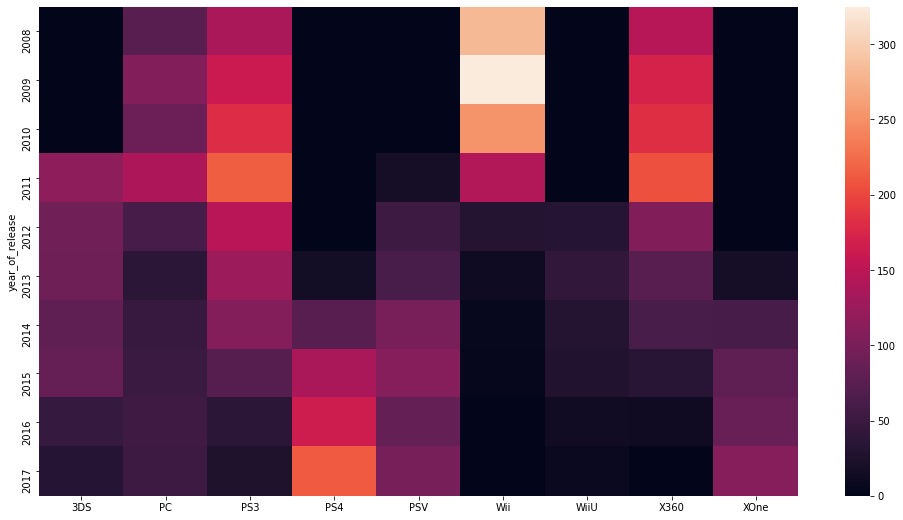

In [66]:
# визуализируем
plt.figure(figsize=(17,9))
sns.heatmap(forecast_q.fillna(0))
plt.show()

исходя из полученных данных можем посчитать ожидаемый прирост по платформам, по новым играм.

In [67]:
dic2={}
for platform in forecast_q.columns[1:].to_list():
    estimation = round(forecast_q.loc[for_year, platform] * tempo[platform].median(), 2)
    dic2[platform] = estimation
print(f'Ожидаемые продажи новых игр по платформам в {for_year} году составят:')
pd.DataFrame(dic2, index=['Sales']).T.sort_values(by='Sales', ascending=False)
    

Ожидаемые продажи новых игр по платформам в 2017 году составят:


,Sales
PS4,91.19
XOne,32.78
PSV,4.16
PC,3.88
PS3,3.00
WiiU,2.37
Wii,0.00
X360,0.00


## Распределение продаж в разбивке по платформам

Построим диаграмму размах по всем платформам.

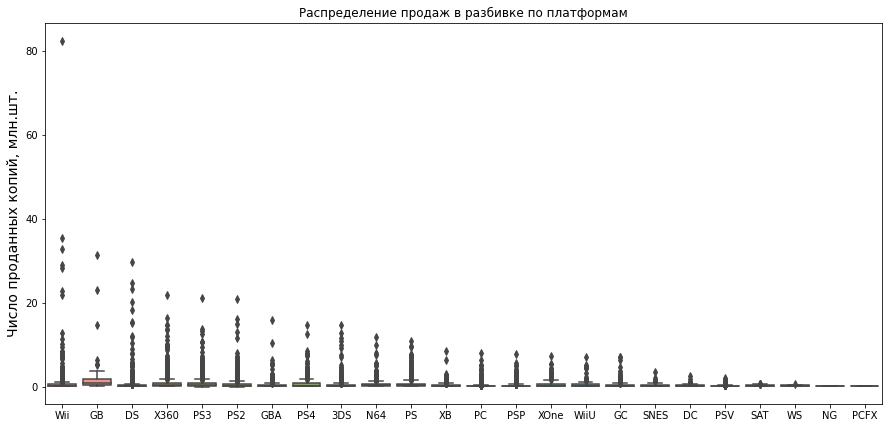

In [68]:
plt.figure(figsize=(15,7))
sns.boxplot(x='platform', y='total_sales', data=df)
plt.title('Распределение продаж в разбивке по платформам')
plt.xlabel("", fontsize=14)
plt.ylabel("Число проданных копий, млн.шт.", fontsize=14)
plt.show()

Много выбросов. Ограничим ось у=(0, 4)

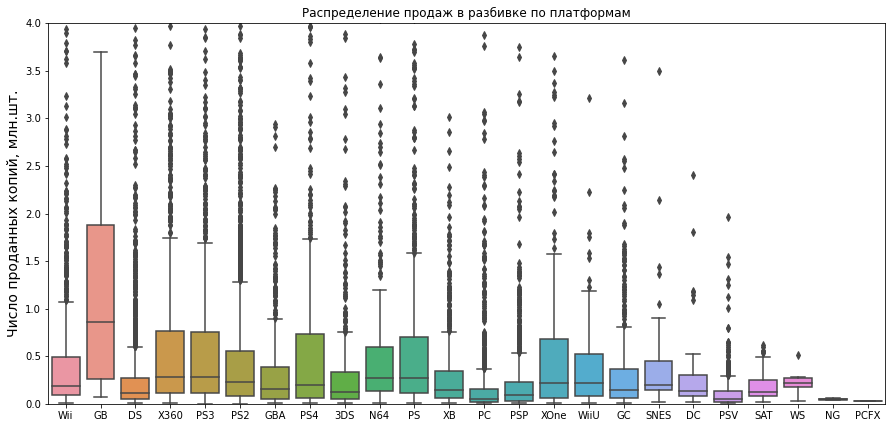

In [69]:
plt.figure(figsize=(15,7))
sns.boxplot(x='platform', y='total_sales', data=df)
plt.title('Распределение продаж в разбивке по платформам')
plt.xlabel("", fontsize=14)
plt.ylabel("Число проданных копий, млн.шт.", fontsize=14)
plt.ylim(0, 4)
plt.show()

Оставим только для "живые" платформы.

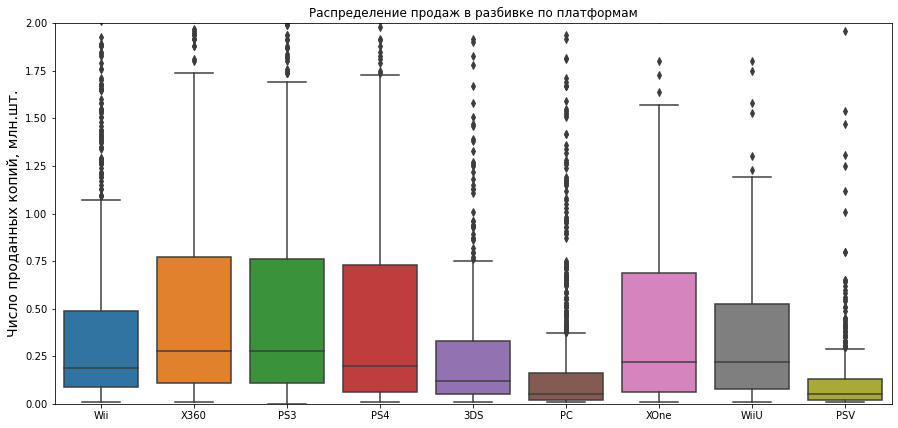

In [70]:
plt.figure(figsize=(15,7))
sns.boxplot(x='platform', y='total_sales', data=df.query('platform in @pl_for_forecast'))
plt.title('Распределение продаж в разбивке по платформам')
plt.xlabel("", fontsize=14)
plt.ylabel("Число проданных копий, млн.шт.", fontsize=14)
plt.ylim(0, 2)
plt.show()

**Выводы** У 20 из 24 платформ наблюдаются существенные выбросы. Наимее предсказуемый результат (большой разброс) показывает платформа GB. Около трети платформ имеют примерно одинаковое медианное значение в районе 250К. Лидеры, PS3, PS4, X360, XOne имеют очень схожие распределения, при этом родственные платформы почти неразличимы. 

## Влияние отзывов на продажи.

Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

На примере популярной платформы PS4, тзучим влияние оценок критиков и польсователей на объем продаж. Отобразим зависимость объема продаж от оценок. Для наглядности визуализации приведёи оценки к одному порядку.

In [71]:
# оставляем записи только с оценкой (либо критиков, либо пользователей)
dft38 = df.loc[(df['critic_score'] != 0) | (df['user_score'] != 0)]
# оставляем записи только по платформе PS4
dft38 = dft38.query('platform == "PS4"')
# уменьшаем порядок оценки критиков, т.е. от вида 0...100 к виду 0...10
dft38['critic_score'] = dft38['critic_score']/10
dft38.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,12.62,9.70,8.30,M
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,8.58,8.20,4.30,E
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,7.66,8.30,5.70,M
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,7.60,8.50,5.00,E
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,7.17,8.70,6.50,M


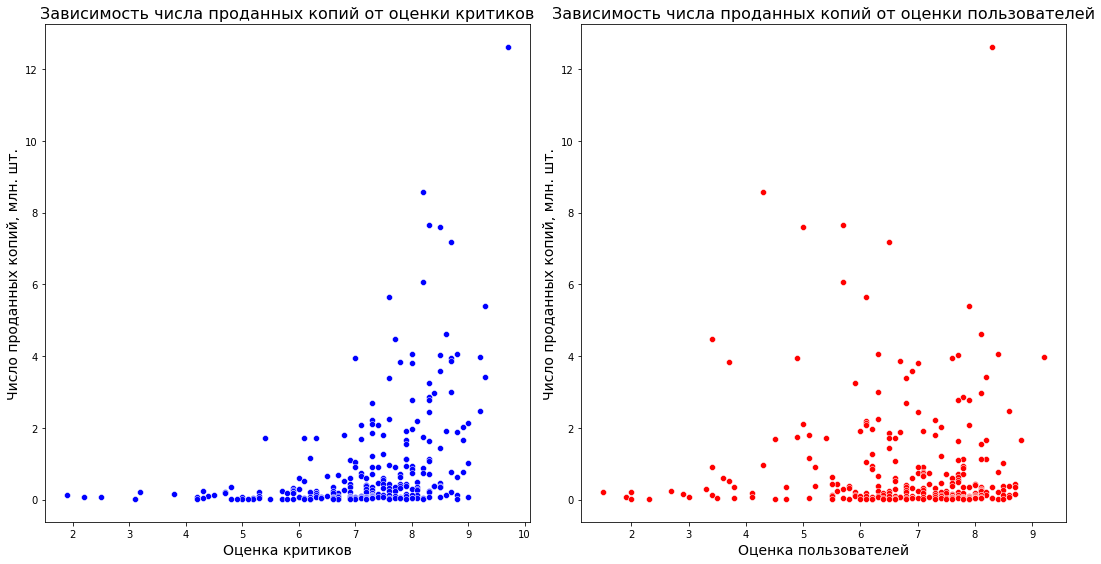

In [72]:
fig4 = plt.figure(figsize=(15,15))
ax1 = fig4.add_subplot(2,2,1)
ax2 = fig4.add_subplot(2,2,2)

sns.scatterplot(x='critic_score', y='total_sales', data=dft38, color='b', ax = ax1)
ax1.set_title('Зависимость числа проданных копий от оценки критиков', fontsize=16)
ax1.set_xlabel("Оценка критиков", fontsize=14)
ax1.set_ylabel("Число проданных копий, млн. шт.", fontsize=14)

sns.scatterplot(x='user_score', y='total_sales', data=dft38, color='r', ax = ax2)
ax2.set_title('Зависимость числа проданных копий от оценки пользователей', fontsize=16)
ax2.set_xlabel("Оценка пользователей", fontsize=14)
ax2.set_ylabel("Число проданных копий, млн. шт.", fontsize=14)

fig4.tight_layout()

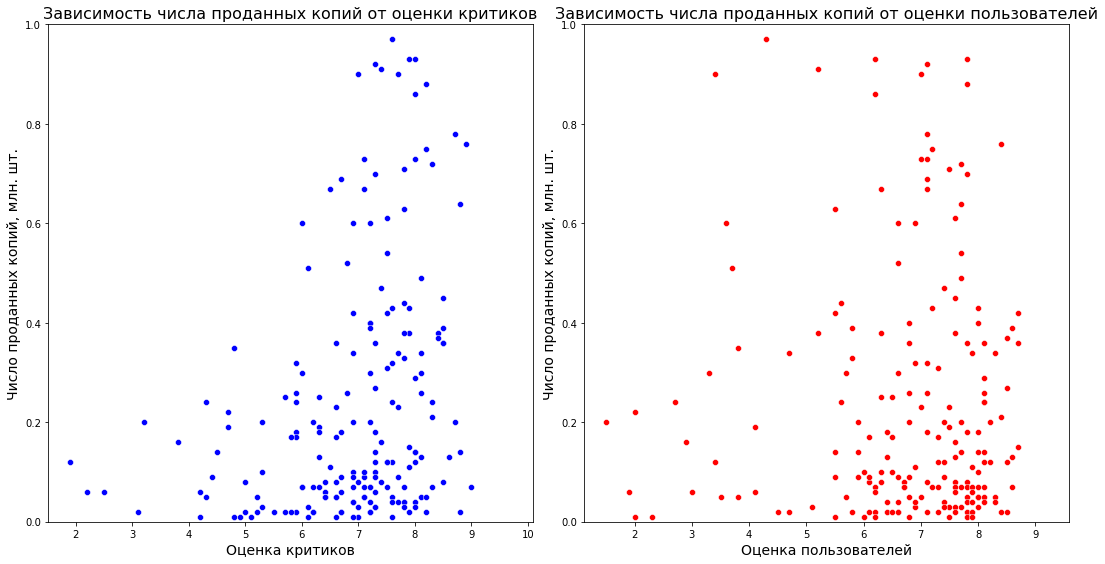

In [73]:
# рассотрим область от 0 до 1 млн. копий подробнее
ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
fig4

Для обеих оценок характерно больше число оценок выше 5. Более явно выделяется связь между объемом продаж и оценкой критиков. Так, например, все игры с продажами более 400К копий, имеют оценку критиков выше 6. Возможно, именно оценка критика является одним из основных критериев в выборе игры/покупке пользователем, что и увеличивает продажи. Т.е. все игры с высокими продажами имеюв высокую оценку. Однако, обратное утверждение будет не всегда верным, не все игры с высокой оценкой показывают высокие продажи. Здесь причиной может быть относительная "свежесть" игры, т.е. как было отмечено ранее, среднегодовой объем продаж игры для PS4 порядка 400К и, если игра вышла в 2016 году(таких у PS4 164), то скорее всего, она не сможет за год показать результат больше 0.4-0.5 млн.копий.  

In [74]:
dft38['year_of_release'].value_counts()

2016    103
2015     90
2014     52
2013     15
Name: year_of_release, dtype: int64

В нашей выборке почти 40% (103 из 260) игр 2016 года.

In [75]:
dft38.query('year_of_release ==2016')['total_sales'].describe()

count   103.00
mean      0.56
std       1.17
min       0.01
25%       0.04
50%       0.13
75%       0.39
max       7.60
Name: total_sales, dtype: float64

У 75% игр, выпущенных в 2016 году объем продаж менее 400К. Медианное значение всего 130К, что при среднем в 561К говорит о наличии очень популярных игр с рекодвнями продажами.

Отдельно посмотрим на 2016 год

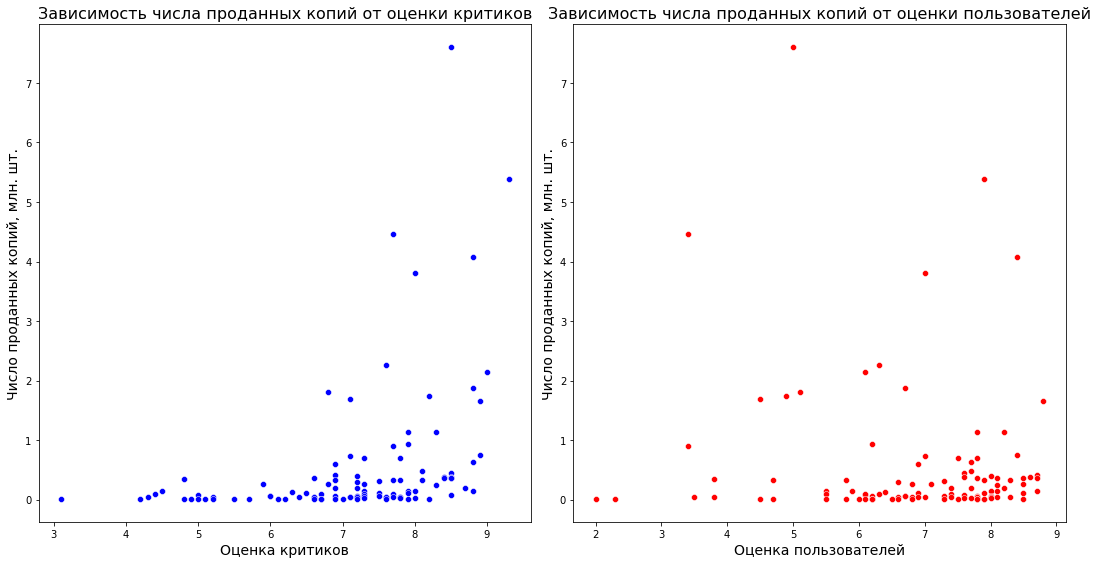

In [76]:
fig5 = plt.figure(figsize=(15,15))
ax1 = fig5.add_subplot(2,2,1)
ax2 = fig5.add_subplot(2,2,2)

sns.scatterplot(x='critic_score', y='total_sales', data=dft38.query('year_of_release ==2016'), color='b', ax = ax1)
ax1.set_title('Зависимость числа проданных копий от оценки критиков', fontsize=16)
ax1.set_xlabel("Оценка критиков", fontsize=14)
ax1.set_ylabel("Число проданных копий, млн. шт.", fontsize=14)

sns.scatterplot(x='user_score', y='total_sales', data=dft38.query('year_of_release ==2016'), color='r', ax = ax2)
ax2.set_title('Зависимость числа проданных копий от оценки пользователей', fontsize=16)
ax2.set_xlabel("Оценка пользователей", fontsize=14)
ax2.set_ylabel("Число проданных копий, млн. шт.", fontsize=14)

fig5.tight_layout()

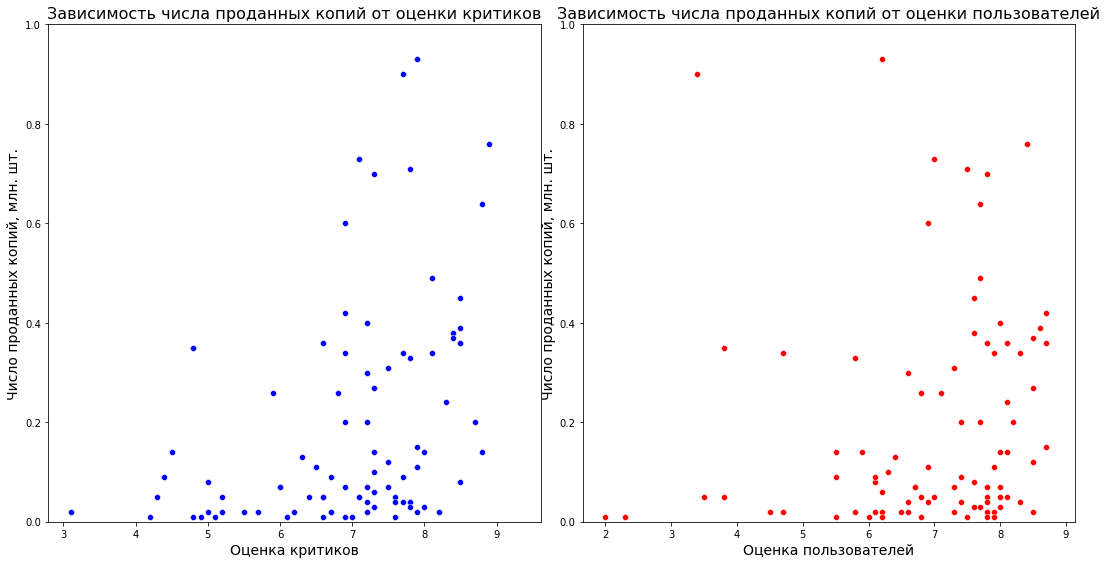

In [77]:
# рассотрим область от 0 до 1 млн. копий подробнее
ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
fig5

Картина особе не поменялась. Важно отметить, что скорее всего, оценка пользователя оказывает незначительное влияние на объем продаж. Так на диаграммах присутствуют несколько игр со значительными объемами и высокой оценкой критиков, но оценка пользователей показывает скорее неудовлетворённость (7.7 критики vs 3.4 пользователи).

Посчитаем коэффициент корреляции Пирсона

In [78]:
print('Корреляция "продажи - оценка критиков"      :', dft38['total_sales'].corr(dft38['critic_score']))
print('Корреляция "продажи - оценка пользователей" :', dft38['total_sales'].corr(dft38['user_score']))

Корреляция "продажи - оценка критиков"      : 0.4009379592261941
Корреляция "продажи - оценка пользователей" : -0.034816696028689934


Корреляция "продажи - оценка критиков" в 0.4 говорит о наличии положительной связи, однако не слишком сильной. 
Корреляция "продажи - оценка пользователей" в -0.03 говорит об отсутствии мсвязи

Сравним с данныпи по платформе XOne

In [79]:
# оставляем записи только с оценкой (либо критиков, либо пользователей)
dft39 = df.loc[(df['critic_score'] != 0) | (df['user_score'] != 0)]
# оставляем записи только по платформе PS4
dft39 = dft39.query('platform == "XOne"')
# уменьшаем порядок оценки критиков, т.е. от вида 0...100 к виду 0...10
dft39['critic_score'] = dft39['critic_score']/10
dft39.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
165,Grand Theft Auto V,XOne,2014,Action,2.81,2.19,0.00,0.47,5.47,9.70,7.90,M
179,Call of Duty: Advanced Warfare,XOne,2014,Shooter,3.22,1.55,0.01,0.48,5.26,8.10,5.40,M
242,Halo 5: Guardians,XOne,2015,Shooter,2.78,1.27,0.03,0.41,4.49,8.40,6.40,T
270,Fallout 4,XOne,2015,Role-Playing,2.51,1.32,0.01,0.38,4.22,8.80,6.20,M
373,Assassin's Creed: Unity,XOne,2014,Action,2.27,0.90,0.00,0.33,3.50,7.20,4.10,M


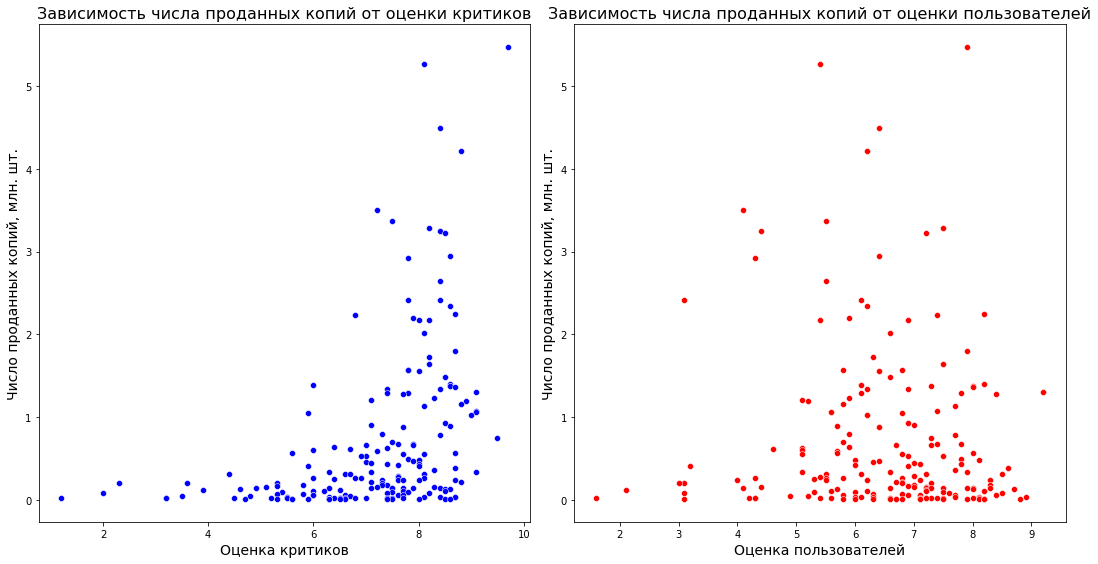

In [80]:
fig39 = plt.figure(figsize=(15,15))
ax1 = fig39.add_subplot(2,2,1)
ax2 = fig39.add_subplot(2,2,2)

sns.scatterplot(x='critic_score', y='total_sales', data=dft39, color='b', ax = ax1)
ax1.set_title('Зависимость числа проданных копий от оценки критиков', fontsize=16)
ax1.set_xlabel("Оценка критиков", fontsize=14)
ax1.set_ylabel("Число проданных копий, млн. шт.", fontsize=14)

sns.scatterplot(x='user_score', y='total_sales', data=dft39, color='r', ax = ax2)
ax2.set_title('Зависимость числа проданных копий от оценки пользователей', fontsize=16)
ax2.set_xlabel("Оценка пользователей", fontsize=14)
ax2.set_ylabel("Число проданных копий, млн. шт.", fontsize=14)

fig39.tight_layout()

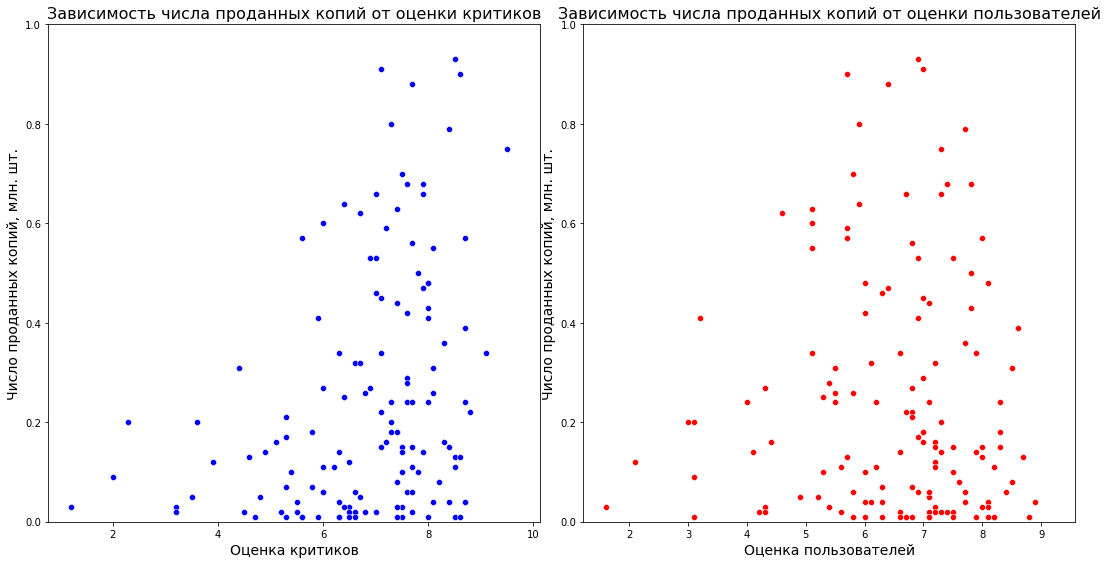

In [81]:
# рассотрим область от 0 до 1 млн. копий подробнее
ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
fig39

Посчитаем коэффициент корреляции Пирсона

In [82]:
print('Корреляция "продажи - оценка критиков"      :', dft39['total_sales'].corr(dft39['critic_score']))
print('Корреляция "продажи - оценка пользователей" :', dft39['total_sales'].corr(dft39['user_score']))

Корреляция "продажи - оценка критиков"      : 0.40690920223173416
Корреляция "продажи - оценка пользователей" : -0.07189653087308982


Картина для платформы XOne схожа с PS4.

## Продажи по жанрам

In [83]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76,8.00,E
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82,8.30,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80,8.00,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,0,0.00,n/a
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,29.80,89,8.50,E


Посмотрим на выпуск игр по жанрам.

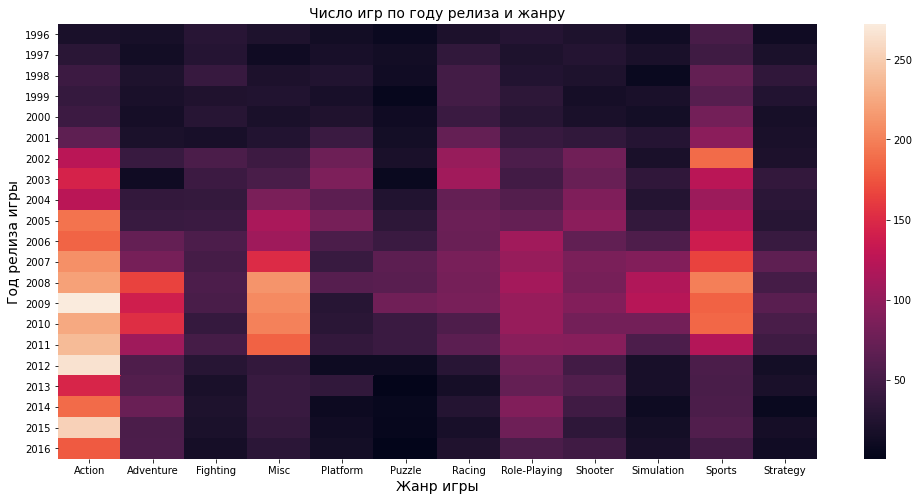

In [84]:
plt.figure(figsize=(17,8))
sns.heatmap(df.pivot_table(index='year_of_release', columns='genre', values='name', aggfunc='count'))
plt.title('Число игр по году релиза и жанру', fontsize=14)
plt.xlabel('Жанр игры', fontsize=14)
plt.ylabel('Год релиза игры', fontsize=14)
plt.show()

Продажи игр по жанрам и году релиза

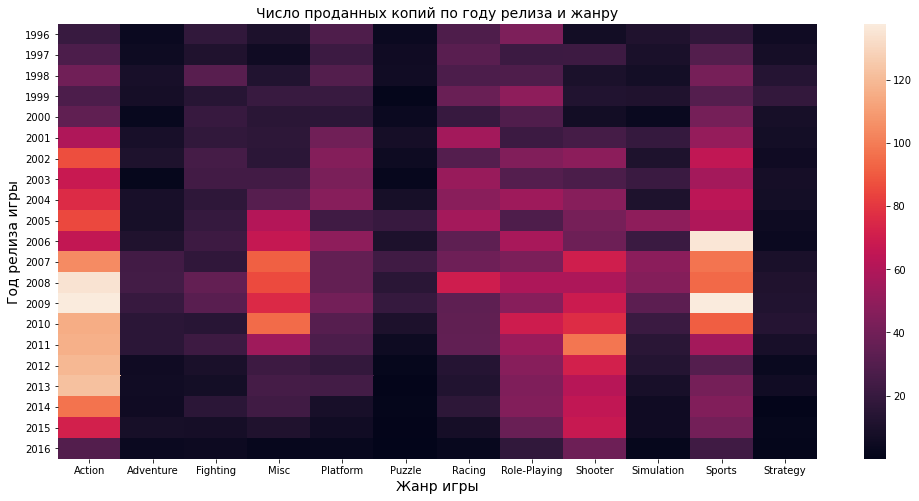

In [85]:
plt.figure(figsize=(17,8))
sns.heatmap(df.pivot_table(index='year_of_release', columns='genre', values='total_sales', aggfunc='sum'))
plt.title('Число проданных копий по году релиза и жанру', fontsize=14)
plt.xlabel('Жанр игры', fontsize=14)
plt.ylabel('Год релиза игры', fontsize=14)
plt.show()

Построим таблицу жанр - количество игр - число проданных копий - среднее число проданных крпий одной игры

In [86]:
dft40 = df.groupby('genre').agg({'name':'count', 'total_sales':'sum'})
dft40.rename(columns = {'name' : 'g_qty', 'total_sales' : 'c_qty'}, inplace = True)
# добавим столбец с отношение числа проданных копий к числу игр
dft40['c_per_g'] = round(dft40['c_qty'] / dft40['g_qty'], 2)
dft40.sort_values(by='c_per_g', ascending=False).reset_index()

,genre,g_qty,c_qty,c_per_g
0,Shooter,1218,963.79,0.79
1,Platform,795,595.14,0.75
2,Role-Playing,1410,874.20,0.62
3,Racing,1191,686.32,0.58
4,Sports,2209,1250.34,0.57
5,Action,3214,1641.49,0.51
6,Fighting,763,387.73,0.51
7,Misc,1679,767.27,0.46
8,Simulation,828,374.95,0.45
9,Puzzle,521,155.68,0.30


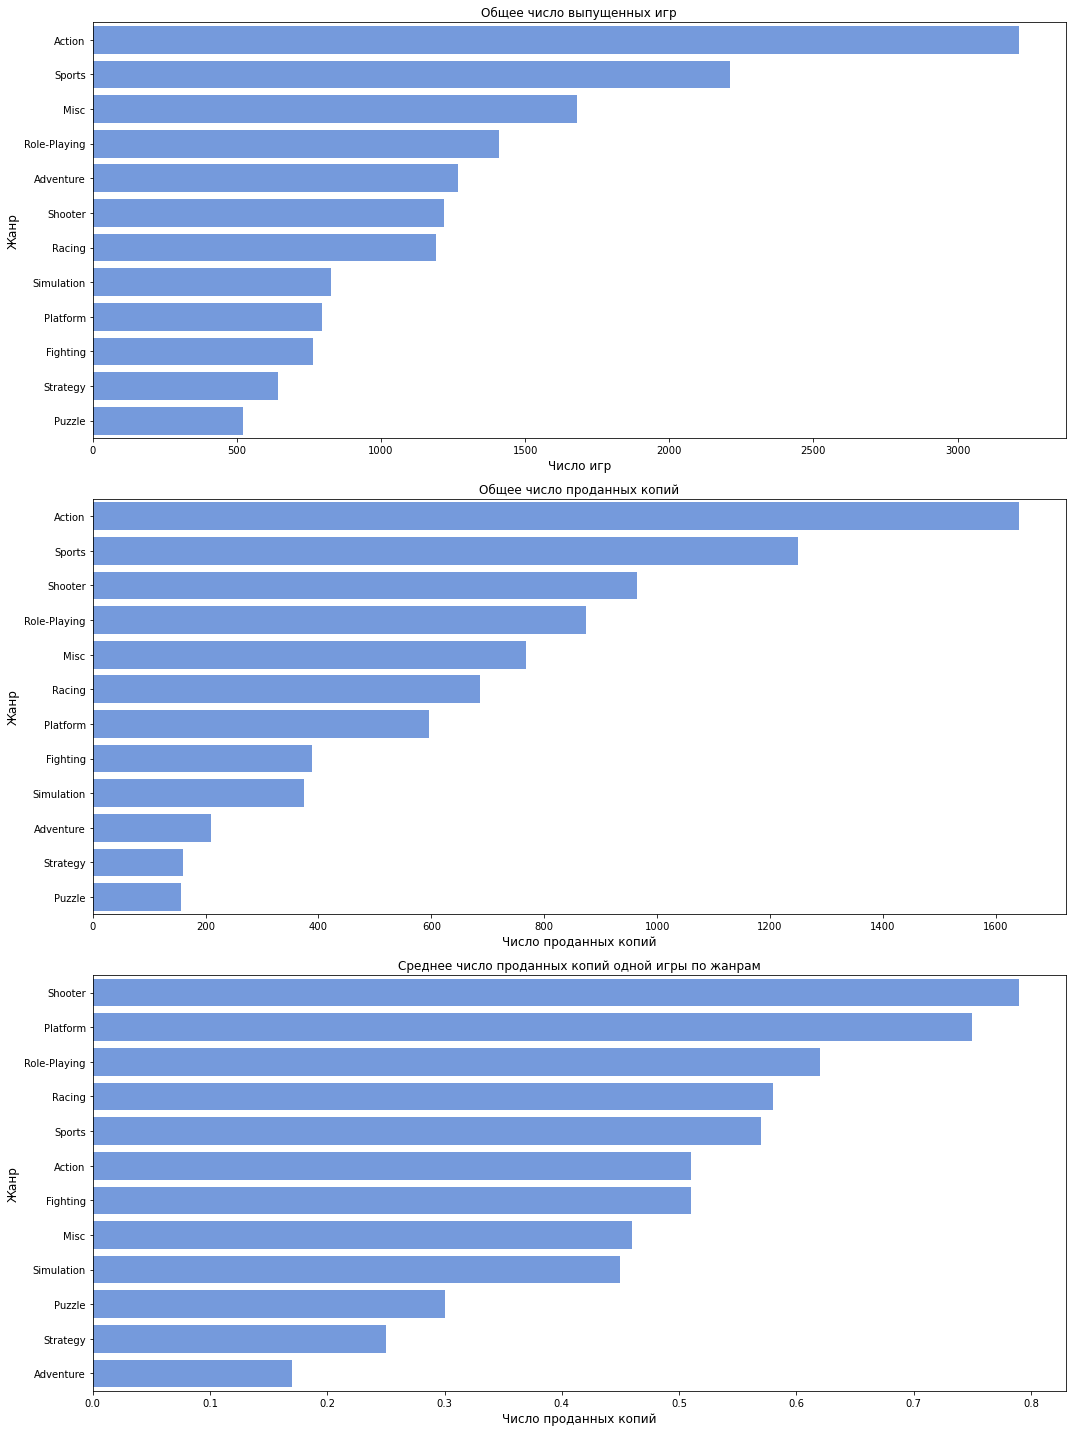

In [87]:
# визуализируем
fig40 = plt.figure(figsize=(15,20))
ax1 = fig40.add_subplot(3,1,1)
ax2 = fig40.add_subplot(3,1,2)
ax3 = fig40.add_subplot(3,1,3)

sns.barplot(y='genre', x='g_qty', data=dft40.sort_values(by='g_qty', ascending=False).reset_index(), color='cornflowerblue', ax = ax1)
ax1.set_title('Общее число выпущенных игр', fontsize=12)
ax1.set_xlabel('Число игр', fontsize=12)
ax1.set_ylabel('Жанр', fontsize=12)

sns.barplot(y='genre', x='c_qty', data=dft40.sort_values(by='c_qty', ascending=False).reset_index(), color='cornflowerblue', ax = ax2)
ax2.set_title('Общее число проданных копий', fontsize=12)
ax2.set_xlabel('Число проданных копий', fontsize=12)
ax2.set_ylabel('Жанр', fontsize=12)

sns.barplot(y='genre', x='c_per_g', data=dft40.sort_values(by='c_per_g', ascending=False).reset_index(), color='cornflowerblue', ax = ax3)
ax3.set_title('Среднее число проданных копий одной игры по жанрам', fontsize=12)
ax3.set_xlabel('Число проданных копий', fontsize=12)
ax3.set_ylabel('Жанр', fontsize=12)

fig40.tight_layout()

**Выводы**
- по числу выпущенных игр в лидерах Action, Sports, Misc
- по числу проданных копий в лидерах Action, Sports, Shooter
- по числу проданных копий на игру жанра в лидерах Shooter, Platform, Role-Playing

Исходя из этого, можно говорить, что с точки зрения раброботки, наибольшую прибыль с высокой вероятность можно получть для игр в жанре Shooter, Platform. Однако, в случае с Platform, необходимо отметить, что для анализа используются данные без разбивки по году реализации. В этом случае, возможно, что текущий спрос на игры подобного жанра находится на достаточно низком уровне в сравнении с прошедшими периодами. Косвенно об этом может говорить, например, падение выпуска игр жанра в последние несколько лет.

# Составление портрета пользователя

## Портрет пользователя  Северной Америки 

Напишем функции для подготовки данных и визуализации для каждого из регионов

In [88]:
def reg_top_5(region):
    # общая сумма продаж по региону
    
    total_copies = df.query('year_of_release > @for_year-10')[region].sum()
    dft41_pl = (
        df.query('year_of_release > @for_year-10')
        .groupby('platform')
        .agg({region:'sum'})
        .sort_values(by=region, ascending=False).head(5))
    # доля от общего объема продаж
    dft41_pl['pl_share'] = round(dft41_pl[region]/total_copies, 4)
    display(dft41_pl)

    dft41_gn = (
        df.query('year_of_release > @for_year-10')
        .groupby('genre')
        .agg({region:'sum'})
        .sort_values(by=region, ascending=False).head(5))
    dft41_gn['gn_share'] = round(dft41_gn[region]/total_copies, 4)
    display(dft41_gn)
    
    dft41_rt = (
        df.query('year_of_release > @for_year-10')
        .groupby('rating')
        .agg({region:'sum'})
        .sort_values(by=region, ascending=False).head(5))
    dft41_rt['rt_share'] = round(dft41_rt[region]/total_copies, 4)
    display(dft41_rt)
    
    # визуализируем
    fig41 = plt.figure(figsize=(15,9))
    ax1 = fig41.add_subplot(3,1,1)
    ax2 = fig41.add_subplot(3,1,2)
    ax3 = fig41.add_subplot(3,1,3)

    dic41 = {'na_sales':'Северная Америка',
             'eu_sales':'Европа',
             'jp_sales':'Япония'}

    sns.barplot(y='platform', x='pl_share', data=dft41_pl.reset_index(), color='cornflowerblue', ax = ax1)
    ax1.set_title(f'ТОП-5 платформ по продажам в регионе {dic41[region]}', fontsize=14)
    ax1.set_xlabel('Доля в общем объеме продав в регионе', fontsize=12)
    ax1.set_ylabel('Платформа', fontsize=12)

    sns.barplot(y='genre', x='gn_share', data=dft41_gn.reset_index(), color='cornflowerblue', ax = ax2)
    ax2.set_title(f'ТОП-5 жанров по продажам в регионе {dic41[region]}', fontsize=14)
    ax2.set_xlabel('Доля в общем объеме продав в регионе', fontsize=12)
    ax2.set_ylabel('Жанр', fontsize=12)
    
    sns.barplot(y='rating', x='rt_share', data=dft41_rt.reset_index(), color='cornflowerblue', ax = ax3)
    ax3.set_title(f'ТОП-5 жанров по продажам в регионе {dic41[region]}', fontsize=14)
    ax3.set_xlabel('Доля в общем объеме продав в регионе', fontsize=12)
    ax3.set_ylabel('Рейтинг ESRB', fontsize=12)

    fig41.tight_layout()
    
    return

,na_sales,pl_share
platform,,
X360,490.69,0.27
PS3,349.13,0.19
Wii,332.87,0.18
DS,198.73,0.11
PS4,108.74,0.06


,na_sales,gn_share
genre,,
Action,433.74,0.24
Shooter,311.26,0.17
Sports,276.27,0.15
Misc,211.61,0.12
Role-Playing,155.81,0.09


,na_sales,rt_share
rating,,
E,536.93,0.30
M,502.60,0.28
T,303.41,0.17
E10+,251.88,0.14
n/a,218.51,0.12


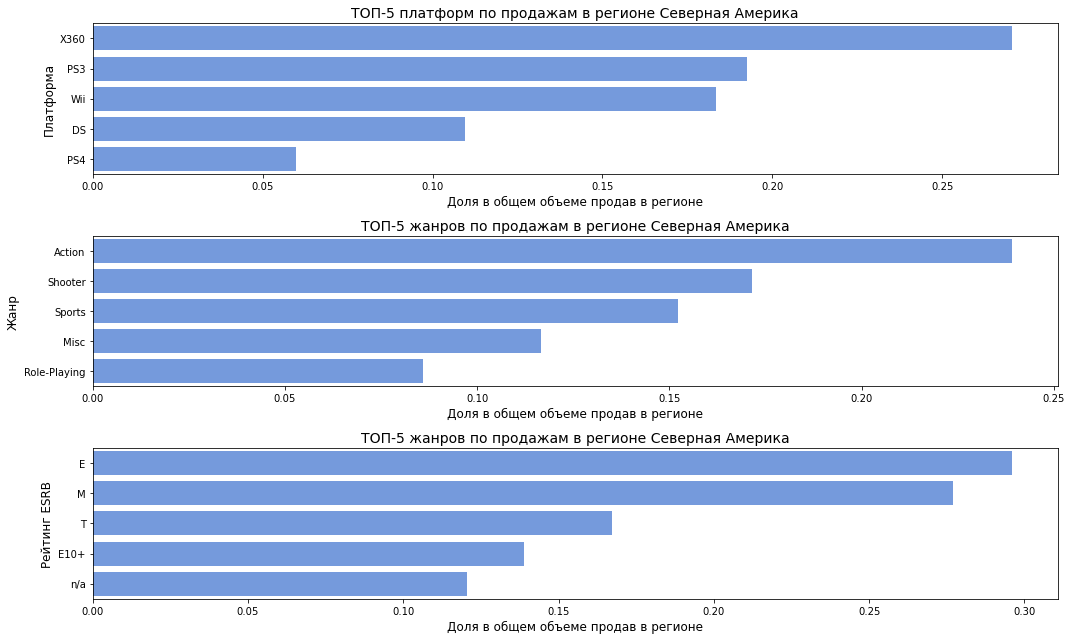

In [89]:
reg_top_5('na_sales')

## Портрет пользователя  Европы

,eu_sales,pl_share
platform,,
PS3,293.73,0.24
X360,234.88,0.19
Wii,170.74,0.14
PS4,141.09,0.12
PC,92.17,0.08


,eu_sales,gn_share
genre,,
Action,310.59,0.26
Shooter,208.35,0.17
Sports,185.19,0.15
Misc,107.00,0.09
Role-Playing,94.46,0.08


,eu_sales,rt_share
rating,,
M,362.65,0.30
E,326.61,0.27
n/a,188.85,0.16
T,187.62,0.15
E10+,144.53,0.12


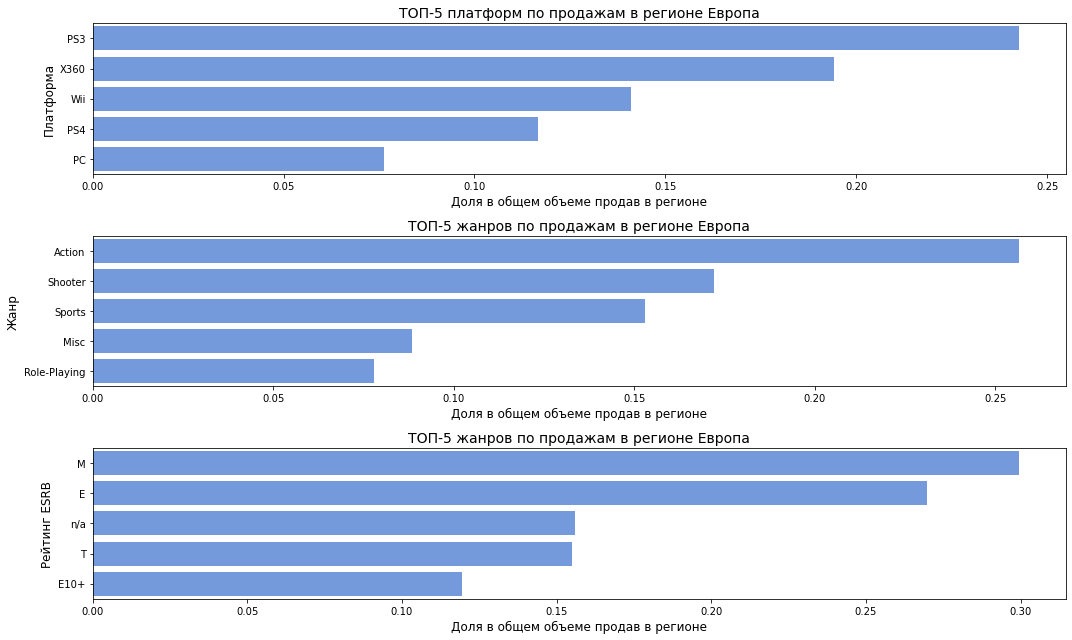

In [90]:
reg_top_5('eu_sales')

## Портрет пользователя  Японии

,jp_sales,pl_share
platform,,
3DS,100.62,0.24
DS,76.12,0.18
PS3,74.11,0.17
PSP,60.46,0.14
Wii,47.01,0.11


,jp_sales,gn_share
genre,,
Role-Playing,138.12,0.32
Action,90.16,0.21
Misc,37.33,0.09
Sports,30.69,0.07
Adventure,23.36,0.05


,jp_sales,rt_share
rating,,
n/a,220.60,0.52
E,77.17,0.18
T,64.51,0.15
M,39.33,0.09
E10+,25.67,0.06


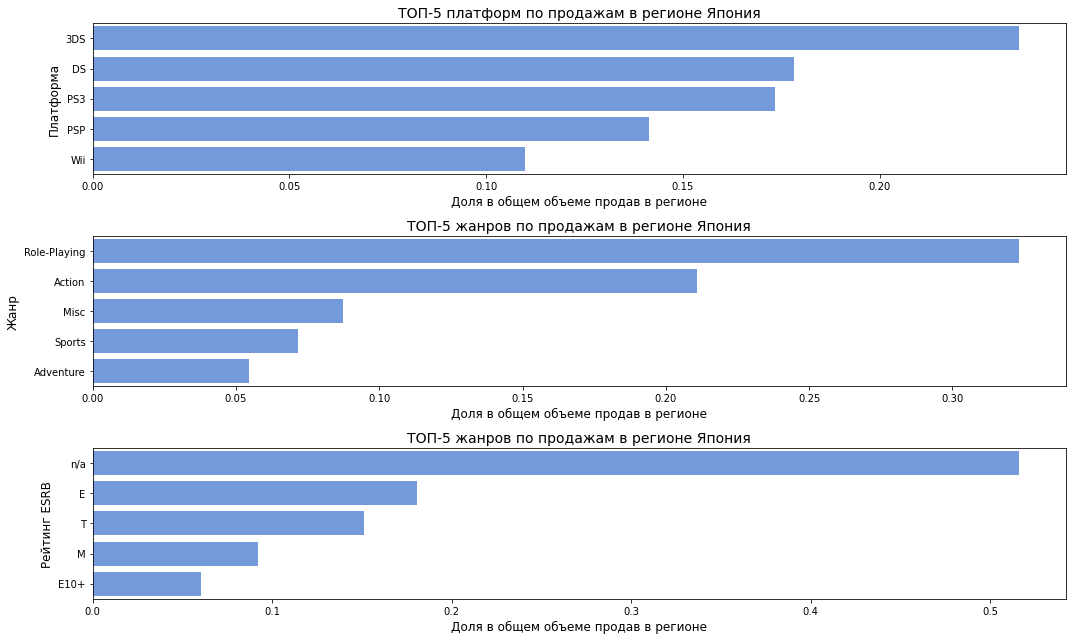

In [91]:
reg_top_5('jp_sales')

**Выводы**  

- **Платформы.** Лидером рынка СА является продукт местной компании Microsoft - Х360. В ТОП-5 попали разные платформы, как с точки зрения компании-производителя, так и по типу (портативные/стационарные). Несущественная разница между 2 и 3. Представлены платформы трёх производителей. Чуть более трети рынка Европы занимают платформы SONY(PS3, PS4).  В ТОП-5 нет портативных платформ, но  пятое место за PC. Представлены платформы трёх производителей + PC. Отличительной чертой Японского рынка является то, что в ТОП-5 попали платформы только двух Японских компаний Nintendo и SONY. На 1-ом, 2-ом и 4-ом местах портативные платформы (DS, 3DS, PSP) на долю которых приходится  более 55% рынка.  Доля платформ SONY - 33%. Для всех платформ из ТОП-5 рынок Японии является "домашним" (не требуется локализация/высокая доступность игр на родном языке). Для всех регионов, общая доля ТОП-5 около 80%.

- **Жанры.** Более 55% рынков СА и Европы приходится на первые три жанра - Action, Shooter , Sports. Распределение внутри тройки для указанных регионов одинаково. Более того, для рынков этих регионов сисок ТОП-5 идентичен по порядку и составу жанров. Рынок Японии имеет два существенных отличия. Во-первых, лидер здесь Role-Playing, которому принадлежит почти треть рынка. Во-вторых, один из лидеров СА и Европы, жанр  Shooter, с долей более 17%, вообще не попал в ТОП-5 жанров Японии. Вместо него в ТОП-5 игры жанра Adventure  с долей  5%. Можно говорить, что тут ярко выражены национальные особенности.

- **Рейтинг.** Помним, что 40% игр не имеют рейтинга. Состав ТОП-5 для всех трёх регионов одинаков. Но, если игры без рейтинга в СA и Европе имеют долю 12-15%, то в Японии доля таких игр больше 50%, что сопоставимо с общей долей лидеров  «E» («Everyone» — «Для всех») и «M» («Mature» — «От 17 лет»)  на рынках СА и Европы. Игры с рейтингом  «T» («Teen» — «Подросткам 13—19 лет») имеют примерно равные доли на всех ранках - 15-17%.

# Проверка гипотез

Для проверки гипотез, примем уровень значимости 5%

In [92]:
alpha = .05

## Гипотеза о равенстве средних оценой пользователей платформ Xbox One и PC

**Нулевая и альтернативная гипотезы**  
Н0: среднии оценки пользователей платформ Xbox One и PC равны;  
НА: среднии оценки пользователей платформ Xbox One и PC не равны (различаются)

In [93]:
# формируем выборки
dft51_xo = df.loc[(df['platform'] == 'XOne') & (df['user_score'] != 0) & (df['year_of_release'] > for_year-10)]
dft51_pc = df.loc[(df['platform'] == 'PC') & (df['user_score'] != 0) & (df['year_of_release'] > for_year-10)]
# посмотрим на их размер
print(f'Выборка XOne - {dft51_xo.shape[0]}, выборка PC - {dft51_pc.shape[0]}')

Выборка XOne - 186, выборка PC - 521


Выборки имеют существенное различие в размере и их дисперсии могут быть не равны. Поэтому, сравнивая средние значения t-тестом, при вызове метода scipy.stats.ttest_ind(), укажем equal_var = False

In [94]:
results = stats.ttest_ind(dft51_xo['user_score'], dft51_pc['user_score'], equal_var=False)
print('p-значение', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение 0.10857814109240006
Не получилось отвергнуть нулевую гипотезу


Гипотезу о равенстве средних оценок пользователей платформ Xbox One и PC Гипотезу не удалось отвергнуть.

## Гипотеза о неравенстве средних оценок пользователей жанров Action и Sports

**Нулевая и альтернативная гипотезы**  
Н0: среднии оценки пользователей жанров Action и Sports равны;  
НА: среднии оценки пользователей жанров Action и Sports не равны (различаются)

In [95]:
# формируем выборки
dft51_ac = df.loc[(df['genre'] == 'Action') & (df['user_score'] != 0) & (df['year_of_release'] > for_year-10)]
dft51_sp = df.loc[(df['genre'] == 'Sports') & (df['user_score'] != 0) & (df['year_of_release'] > for_year-10)]
# посмотрим на их размер
print(f'Выборка Action - {dft51_ac.shape[0]}, выборка Sports - {dft51_sp.shape[0]}')

Выборка Action - 1159, выборка Sports - 552


Выборки имеют различие в размере и их дисперсии могут быть не равны. Поэтому, сравнивая средние значения t-тестом, при вызове метода scipy.stats.ttest_ind(), укажем equal_var = False

In [96]:
results = stats.ttest_ind(dft51_ac['user_score'], dft51_sp['user_score'], equal_var=False)
print('p-значение', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение 2.0783430774627042e-13
Отвергаем нулевую гипотезу


p-значение ничножно мало по сравнению с принятым уровнем значимости. Поэтому, гипотезу, что среднии оценки пользователей жанров Action и Sports равны отвергаем.

Видно, что даже при уровене статистической значимости 1% результат проверка обеих гипотез не измениться.

# Выводы и рекомендации

**Игры по году выпуска**  
Пик выпуска игр приходится на 2008-2009 года. С 1996 по 2008 года рост с незначительными колебаниями. Последующее падение связано, вероятно, с кризисом 2008 года. Резкое падение, почти в двое, в 2012. После 2012 и по 2016 число игр примерно на одном уровне. В 2013 году самый низкий показатель за предыдущие 10 лет. Изменение общего числа проданных копий схоже с поведением выпуска игр. Обращает внимание высокое значение числа копий в пересчете на 1 игру для игр 2013 года. Помним, что это год с наименьшим числом выпущенных игр. Все регионы показывают относительно одинаковую динамику по числу копий с поправкой на мультипликатор. Присутствует небольшой отличие для рынка Японии на отрезке 2000-2003 года (другая направленность). Японский рынок показывает относительную стабильность по сравнению с рынками СА и Европы, колебания в пределах 25-75 млн. копий, в то время как рынок СА, на отрезке 1997-2008 годы вырос в 3.5 раза.

**Игры по платформам**  
По числу выпущенных игр и про количеству проданных копий лидирует PS2. В ТОП-5 обоих рейтингов список платформ идентичен, 2 платформы от SONY, 2 от Nintendo и 1 от Microsoft. Среди 5 присутствует 1 портативная платформа (DS). И если по числу проданных копий есть явный лидер - PS2, то по числу игр разрыв между 1 и 2 местами не так значителен. Рейтинг по числу проданных копий имеет более четкие градации внутри ТОП-5.  
Лидер по выпуску игр в год NINTENDO (DS, Wii), наилучший результат - платформа DS в 2008году. Прослеживается плавная, со значительным перекрытием, смена поколений SONY (PS > PS2 > PS3 > PS4), наибольшее число игр выпущено для PS2. Более резкая смена поколений для платформ Microsoft. Лидер по числу проданных копий в год платформы PS2(игры 2004 и 2002) и Wii(игры 2009). По предоставленным данным можно говорить о потенциале роста на платформах PS4, XOne и стабильном состоянии по PС.
В среднем платформы "живут" около 6 лет. PC видится платформой, которая будет существовать всегда. Половина платформ имеют срок от 4 до 10 лет, четверть - менее 4 лет и еще четверть - 10 и белее лет. Для платформ из ТОП-10 характерно более длительное существование - 7-12лет, при медиане 10. Как правило, пик платформы приходится на середину жизненного цикла, т.е. 5-6 годы для ТОП-10 платформ.

**Игры по жанрам**  
По числу выпущенных игр в лидерах Action, Sports, Misc. По числу проданных копий в лидерах Action, Sports, Shooter. По числу проданных копий на игру жанра в лидерах Shooter, Platform, Role-Playing. 
Исходя из этого, можно говорить, что с точки зрения разработки, наибольшую прибыль с высокой вероятность можно получить для игр в жанре Shooter, Platform. Однако, в случае с Platform, необходимо отметить, что для анализа используются данные без разбивки по году реализации. В этом случае, возможно, что текущий спрос на игры подобного жанра находится на достаточно низком уровне в сравнении с прошедшими периодами. Косвенно об этом может говорить, например, падение выпуска игр жанра в последние несколько лет.

**Особенности регионов**  
- *Платформы.* Лидером рынка СА является продукт местной компании Microsoft - Х360. В ТОП-5 попали разные платформы, как с точки зрения компании-производителя, так и по типу (портативные/стационарные). Несущественная разница между 2 и 3. Представлены платформы трёх производителей. Чуть более трети рынка Европы занимают платформы SONY(PS3, PS4).  В ТОП-5 нет портативных платформ, но  пятое место за PC. Представлены платформы трёх производителей + PC. Отличительной чертой Японского рынка является то, что в ТОП-5 попали платформы только двух Японских компаний Nintendo и SONY. На 1-ом, 2-ом и 4-ом местах портативные платформы (DS, 3DS, PSP) на долю которых приходится  более 55% рынка.  Доля платформ SONY - 33%. Для всех платформ из ТОП-5 рынок Японии является "домашним" (не требуется локализация/высокая доступность игр на родном языке). Для всех регионов, общая доля ТОП-5 около 80%.

- *Жанры.* Более 55% рынков СА и Европы приходится на первые три жанра - Action, Shooter , Sports. Распределение внутри тройки для указанных регионов одинаково. Более того, для рынков этих регионов список ТОП-5 идентичен по порядку и составу жанров. Рынок Японии имеет два существенных отличия. Во-первых, лидер здесь Role-Playing, которому принадлежит почти треть рынка. Во-вторых, один из лидеров СА и Европы, жанр  Shooter, с долей более 17%, вообще не попал в ТОП-5 жанров Японии. Вместо него в ТОП-5 игры жанра Adventure  с долей  5%. Можно говорить, что тут ярко выражены национальные особенности.

- *Рейтинг.* Помним, что 40% игр не имеют рейтинга. Состав ТОП-5 для всех трёх регионов одинаков. Но, если игры без рейтинга в СA и Европе имеют долю 12-15%, то в Японии доля таких игр больше 50%, что сопоставимо с общей долей лидеров  «E» («Everyone» — «Для всех») и «M» («Mature» — «От 17 лет»)  на рынках СА и Европы. Игры с рейтингом  «T» («Teen» — «Подросткам 13—19 лет») имеют примерно равные доли на всех ранках - 15-17%.


**Влияние отзывов на продажи**  
Как для оценок критиков, так и для оценок пользователей, характерно большое число оценок выше 5. Более сильная связь (коэффициент корреляции 0.4) между объемом продаж и оценкой критиков. Так, например, все игры с продажами более 400К копий, имеют оценку критиков выше 6. Возможно, именно оценка критика является одним из основных критериев в выборе игры пользователем, что и увеличивает продажи. Т.е. все игры с высокими продажами имеют высокую оценку. Однако, обратное утверждение будет не всегда верным, не все игры с высокой оценкой показывают высокие продажи. Причиной может быть относительная "свежесть" игры, т.е. как было отмечено ранее, среднегодовой объем продаж игры для PS4 порядка 400К и, если игра вышла в 2016 году(таких у PS4 164), то скорее всего, она не сможет за год показать результат больше 0.4-0.5 млн.копий. 

**Рекомендации**
Исходя из проведенного анализа, следует обратить внимание на игры удовлетворяющие следующим условиям:
1. Платформа: PS4, XOne
2. Жанры: Action, Shooter, Sports 
3. Рейтинг ESRB: «E», «M», «T»
4. Высокая оценка критика 